In [52]:
import numpy as np
import pandas as pd
from datetime import datetime
from multiprocessing import Pool
import subprocess, shlex
import requests
from io import StringIO as sio
from io import StringIO
from collections import defaultdict

import dendropy
import itertools
from tqdm.notebook import trange, tqdm

In [53]:
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex
from matplotlib.transforms import ScaledTranslation
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import src.baltic as bt


In [54]:
from functools import reduce

In [242]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['font.size'] = 7

plt.rcParams['font.sans-serif'] = ['Arial']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [5]:
def commonAncestor(tre,descendants,strict=False):
        """
        Find the most recent node object that gave rise to a given list of descendant branches.
        """
        assert len(descendants)>1,'Not enough descendants to find common ancestor: %d'%(len(descendants))
        paths_to_root={k.index: set() for k in descendants} ## for every descendant create an empty set
        for k in descendants: ## iterate through every descendant
            cur_node=k ## start descent from descendant
            while cur_node.parent: ## while not at root
                paths_to_root[k.index].add(cur_node) ## remember every node visited along the way
                cur_node=cur_node.parent ## descend

        return sorted(reduce(set.intersection,paths_to_root.values()),key=lambda k: k.height)[-1] ## return the most recent branch that is shared across all paths to root


In [6]:
# isl info
isl_info = pd.read_csv('isl_info_h5.csv', sep='\t', keep_default_na=False)
# seg info
seq_info = pd.read_csv('seg_info_h5.csv', sep='\t', keep_default_na=False)
seg2isl = seq_info.set_index('Segment_Id')['Isolate_Id'].to_dict()
isl_info.shape, seq_info.shape

((3781, 26), (34760, 16))

In [7]:
segments = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']

In [8]:
n8_set = isl_info.query('subtype == "H5N8"')
print(n8_set.shape)

n8_set_2019 = n8_set[n8_set.date > '2019-12-30']
print(n8_set_2019.shape)

(2007, 26)
(1390, 26)


In [9]:
seq_info.head()

,Isolate_Id,Isolate_Name,Segment_Id,Segment_Name,Sequence,seq_len,count_a,count_c,count_g,count_t,count_other,count_N,count_gap,count_q,count_invalid,Align_sequences
0,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846416,HA,agcaggggtttactctgtcaaaatggagaacatagtacttcttctt...,1762,604,330,408,420,0,0,0,0,0,atggagaacatagtacttcttcttgcaatagttagccttgttaaaa...
1,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846411,MP,aagcaggtagatattgaaagatgagtcttctaaccgaggtcgaaac...,1005,281,219,275,230,0,0,0,0,0,atgagtcttctaaccgaggtcgaaacgtacgttctctctatcgtcc...
2,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846415,NA,atgaatccaaatcagaagataataacaattggctctgtctctctaa...,1440,449,279,338,374,0,0,0,0,0,atgaatccaaatcagaagataataacaattggctctgtctctctaa...
3,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846409,NP,agcagggtagataatcactcactgagtgacatcaacatcatggcgt...,1551,492,313,417,328,0,0,0,0,1,atggcgtctcaaggcaccaaacgatcttatgaacagatggaaactg...
4,EPI_ISL_1005680,A/common_teal/Chany_Lake/213/2020,EPI1846410,NS,gcagggtgacaaaaacataatggatcccaacactatgttaagcttt...,876,282,169,209,216,0,0,0,0,0,atggatcccaacactatgttaagctttcaggtagactgttttcttt...


# build tree

In [78]:
for seg in segments:
    
    tmp = seq_info[(seq_info.Isolate_Id.isin(n8_set_2019.Isolate_Id)) & (seq_info.Segment_Name == seg)]
    
    f = open(f'./data/01_h5n8_after2019/h5n8_{seg}.fasta', 'w')
    
    f2 = open(f'./data/01_h5n8_after2019/meta_{seg}.txt', 'w')
    f2.write('Name,Date,Region,Strain\n')
    
    for _, (isl_acc, isl_name, seg_acc, seq) in tmp[['Isolate_Id', 'Isolate_Name', 'Segment_Id', 'Sequence']].iterrows():
        date = n8_set_2019.loc[n8_set_2019.Isolate_Id==isl_acc, 'date'].values[0]
        date = bt.decimalDate(date, fmt='%Y-%m-%d')
        region = n8_set_2019.loc[n8_set_2019.Isolate_Id==isl_acc, 'Location'].values[0].split(' / ')[0]
        f.write(f'>{isl_acc}\n{seq}\n')
        f2.write(f'{isl_acc},{date},{region},{isl_name}\n')
        
f.close()
f2.close()

In [82]:
for seg in segments:
    cmd = f'mafft --anysymbol --auto ./data/01_h5n8_after2019/h5n8_{seg}.fasta > ./data/01_h5n8_after2019/h5n8_{seg}.align.fasta'
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [87]:
for seg in segments:
    cmd = f'treetime --aln ./data/01_h5n8_after2019/h5n8_{seg}.align.fasta --dates ./data/01_h5n8_after2019/meta_{seg}.txt --name-column Name --date-column Date --reroot least-squares --reconstruct-tip-states --outdir ./data/01_h5n8_after2019/treetime_{seg}/'
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})

# calculate pairwise distance matrix

In [88]:
tree_file = f'./data/01_h5n8_after2019/treetime_{seg}/divergence_tree.nexus'

tree = dendropy.Tree.get(path=tree_file, schema='nexus', extract_comment_metadata=True, rooting='default-rooted', preserve_underscores=True, suppress_internal_node_taxa=False) 

pdc = tree.phylogenetic_distance_matrix()

mpd_l = []
for node in tree.preorder_internal_node_iter():
    community_i = [n.taxon for n in node.leaf_nodes()]
    mpd = pdc.mean_pairwise_distance(filter_fn=lambda taxon: taxon in community_i)
    node.annotations.add_new(name='mpd', value=mpd)
    mpd_l.append(mpd)

In [89]:
def calculate_pairwise_distance(seg):
    # read divergence tree re-rooted using treetime
    tree_file = f'./data/01_h5n8_after2019/treetime_{seg}/divergence_tree.nexus'
    tree = dendropy.Tree.get(path=tree_file, 
                             schema='nexus', 
                             extract_comment_metadata=True, 
                             rooting='default-rooted', 
                             preserve_underscores=True, 
                             suppress_internal_node_taxa=False) 
    # cache pairwise patristic distance
    pdc = tree.phylogenetic_distance_matrix()
    
    # calculate mean patristic distance
    mpd_l = []
    for node in tree.preorder_internal_node_iter():
        community_i = [n.taxon for n in node.leaf_nodes()]
        mpd = pdc.mean_pairwise_distance(filter_fn=lambda taxon: taxon in community_i)
        node.annotations.add_new(name='mpd', value=mpd)
        mpd_l.append(mpd)

    return (seg, (tree, mpd_l))

In [90]:
with Pool(8) as p:
    res = p.map(calculate_pairwise_distance, segments)
    p.close()
    p.join()

tree_dict = dict(res)

# calculate mpd distribution

In [102]:
def find_monophyletic_clades(tree, crit_mpd):
    
    subtrees = []
    visited_nds = []

    for nd in tree.preorder_node_iter():
        
        # if a node belong to a child node of a node visted
        if nd in visited_nds:
            continue

        if nd.is_leaf():
            subtrees.append([nd.taxon.label])
            visited_nds.append(nd)
            continue

        mpd = float(nd.annotations.get_value('mpd'))
        
        # if find a mono-clade, then never visit it's child nodes
        if mpd < crit_mpd:
            subtrees.append([leaf.taxon.label for leaf in nd.leaf_nodes()])
            visited_nds.extend(list(nd.preorder_iter()))
            continue
        
        visited_nds.append(nd)
        
    return subtrees


def cal_mean_cluster_size(clusters):
    M = len(clusters)
    S = np.array([len(cluster) for cluster in clusters])
    N = sum(S)
    return np.sum(np.square(S)) / np.square(N)

In [103]:
def cal_MCS_for_segment(seg):
    
    tree, mpd_l = tree_dict[seg]
    x = np.array(mpd_l)

    MCS = []
    for pct in np.arange(0, 100+0.1, 0.1):
        
        crit_mpd = np.quantile(x, 1-pct/100)
        monophyletic_clades = find_monophyletic_clades(tree, crit_mpd)
        mean_cluster_size = cal_mean_cluster_size(monophyletic_clades)
        MCS.append((pct, mean_cluster_size))

    return seg, np.array(MCS)


In [104]:
with Pool(8) as p:
    res = p.map(cal_MCS_for_segment, segments)
    p.close()
    p.join()

mcs_dict = dict(res)

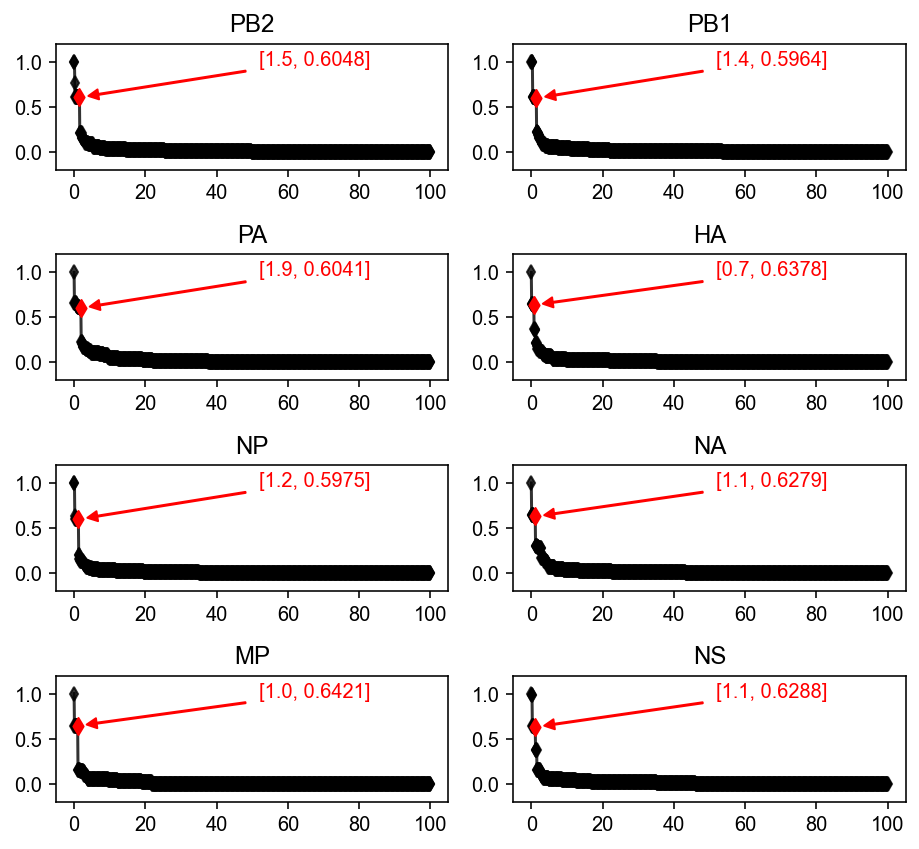

In [120]:
fig, axs = plt.subplots(4, 2, figsize=(6.5, 6), dpi=144)

axs = np.ravel(axs)

final_thr = {'PB2': 1.5, 'PB1': 1.4, 'PA': 1.9, 'HA': 0.7, 'NP': 1.2, 'NA': 1.1, 'MP': 1.0, 'NS': 1.1}

for i, seg in enumerate(segments):
    
    ax = axs[i]
    
    MCS = mcs_dict[seg]
    MCS[0, 1] = 1

    x = final_thr[seg]
    y = MCS[int(x*10), 1]

    ax.scatter(x=[x], y=[y], color='red', zorder=10000, marker='d')

    ax.plot(MCS[:, 0], MCS[:, 1], marker='d', alpha=.8, color='black', markersize=5)
    ax.set_title(seg)
    ax.set_ylim(-0.2, 1.2)

    ax.annotate(f'[{x}, {y:.4}]', xy=(x, y),  xycoords='data',
                xytext=(0.8, 0.95), textcoords='axes fraction', color='red',
                arrowprops=dict(edgecolor='red', facecolor='red', shrink=0.05, width=.5, headwidth=5, headlength=5),
                horizontalalignment='right', verticalalignment='top',
               )

plt.tight_layout()

**Supplementary Figure 2 Group threshold**

In [94]:
seg = "NS"
tree, mpd_l = tree_dict[seg]
x = np.array(mpd_l)

for pct in np.arange(0, 3, 0.1):
    
    crit_mpd = np.quantile(x, 1-pct/100)
    monophyletic_clades = find_monophyletic_clades(tree, crit_mpd)
    mean_cluster_size = cal_mean_cluster_size(monophyletic_clades)

    print(f"PCT: {pct:.2f}, MPD: {crit_mpd:.4f}, # of clades: {len(monophyletic_clades)}, Mean cluster size: {mean_cluster_size:.4f}")


NameError: name 'tree_dict' is not defined

In [365]:
seg = "NS"
tree, mpd_l = tree_dict[seg]
x = np.array(mpd_l)

pct = final_thr[seg]-.4
    
crit_mpd = np.quantile(x, 1-pct/100)
monophyletic_clades = find_monophyletic_clades(tree, crit_mpd)
mean_cluster_size = cal_mean_cluster_size(monophyletic_clades)

print(f"pct: {pct:.1f}, mpd: {crit_mpd:.4f}, # sub-groups: {len(monophyletic_clades)}, MCS: {mean_cluster_size:.4f}")
for clade in sorted(monophyletic_clades, key=lambda x: len(x), reverse=True):
    print("  # leaves: ", len(clade))


pct: 0.7, mpd: 0.0080, # sub-groups: 10, MCS: 0.6332
  # leaves:  1067
  # leaves:  291
  # leaves:  13
  # leaves:  10
  # leaves:  4
  # leaves:  1
  # leaves:  1
  # leaves:  1
  # leaves:  1
  # leaves:  1


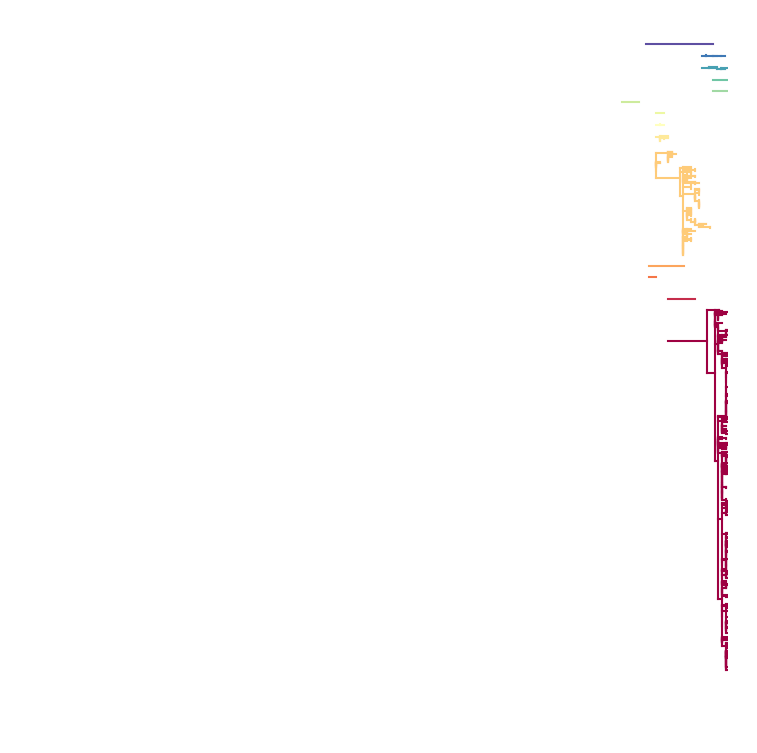

In [351]:
seg = 'NS'
tree, mpd_l = tree_dict[seg]

pct = final_thr[seg]
# pct = 0.7
crit_mpd = np.quantile(np.array(mpd_l), 1-pct/100)
monophyletic_clades = find_monophyletic_clades(tree, crit_mpd)
monophyletic_clades = sorted(monophyletic_clades, key=lambda x: len(x), reverse=True)

treeString = tree.as_string(
    schema='newick',
    suppress_rooting=True,
    suppress_annotations=False,
    suppress_internal_taxon_labels=True,
    annotations_as_nhx=True,
)

ll = bt.loadNewick(StringIO(treeString))

index = 'abcdefghijklmnopq'

subtrees = []
for i, tax_list in enumerate(monophyletic_clades):
    
    nodes = list(filter(lambda x: x.branchType=='leaf' and x.name in tax_list, ll.Objects))
    if len(nodes) == 1:
        subtree = ll.subtree(nodes[0])
    else:
        mrca = ll.commonAncestor(nodes)
        subtree = ll.subtree(mrca)
    
    subtrees.append(subtree)

    
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)
cmap = cm.get_cmap('Spectral', len(subtrees))

cumulative_y=0
for i, subtree in enumerate(sorted(subtrees, key=lambda x: x.root.y)):
    color = to_hex(cmap((i)/len(subtrees)))
    y_attr = lambda k: k.y+cumulative_y
    
    subtree.plotTree(ax, y_attr=y_attr, width=.5, colour=color)
    
    # if len(subtree.getExternal()) > 1:
    #     ax.text(subtree.root.x-subtree.treeHeight, subtree.root.y+cumulative_y, index[i], fontsize=6)
    
    cumulative_y+=subtree.ySpan+30


ax.set_xlim(0, ll.treeHeight*1.1)
ax.set_ylim(-100, ll.ySpan+cumulative_y+10)
    
ax.set(xticks=[], yticks=[])

[ax.spines[loc].set_visible(False) for loc in ax.spines];

# visualization group information for each gene

In [385]:
final_thr = {'PB2': 1.5, 'PB1': 1.4, 'PA': 1.9, 'HA': 0.7, 'NP': 1.2, 'NA': 1.1, 'MP': 1.0, 'NS': 0.6}

In [386]:
def generate_text_string(monophyletic_clades):
    index = 'abcdefghijklmnopq'
    n_clades = len(monophyletic_clades)
    n_leaves = [len(clade) for clade in monophyletic_clades]
    doc = f"Total {sum(n_leaves)} levaes\n"
    ct, nt = 0, 0
    for n_leave in sorted(n_leaves, reverse=True):
        # if n_leave == 1:
        #     nt += 1
        #     continue
        doc += f"* clade {index[ct]}, {n_leave} leaves\n"
        ct += 1
    doc += f"{ct} clades, {nt} unclassfied"
    return doc


def add_heighlight(ax, tree, tax_list, color):
    xpad = tree.treeHeight * 0.05
    nodes = list(filter(lambda x: x.branchType=='leaf' and x.name in tax_list, tree.Objects))
    
    if len(nodes) == 1:
        mrca = nodes[0]
        return Rectangle((mrca.x-xpad, mrca.y-0.5),xpad*2,2)
    # mrca = tree.commonAncestor(nodes)
    
    mrca = commonAncestor(tree, nodes)
    
    height = max(mrca.yRange) - min(mrca.yRange) + 0.5*2
    left = mrca.x - xpad
    lower = min(mrca.yRange) - 0.5
    width = mrca.childHeight - mrca.height + xpad*2
    rect=Rectangle((left,lower),width,height,facecolor=color,alpha=.7,lw=.0,ls='-',zorder=0) 
    
    ax.add_patch(rect)
    
    
def map_group_results(ax, seg):
    tree, mpd_l = tree_dict[seg]
    pct = final_thr[seg]
    crit_mpd = np.quantile(np.array(mpd_l), 1-pct/100)
    monophyletic_clades = find_monophyletic_clades(tree, crit_mpd)
    monophyletic_clades = sorted(monophyletic_clades, key=lambda x: len(x), reverse=True)

    treeString = tree.as_string(
        schema='newick',
        suppress_rooting=True,
        suppress_annotations=True,
        annotations_as_nhx=False,
        suppress_internal_taxon_labels=True,
    )

    tree = bt.loadNewick(StringIO(treeString))

    y_attr=lambda k: k.y
    x_attr=lambda k: k.x

    tree.plotTree(ax, x_attr=x_attr, y_attr=y_attr, width=.7)

    cmap = cm.get_cmap('rainbow', len(monophyletic_clades))
    for i, monophyletic_clade in enumerate(monophyletic_clades):
        color = to_hex(cmap((i+1)/len(monophyletic_clades)))
        add_heighlight(ax, tree, monophyletic_clade, color)
        
    
    doc = generate_text_string(monophyletic_clades)
    
    ax.text(0,0,doc,fontdict={'fontsize':4}, transform=ax.transAxes)

    ax.set_xlim(-tree.treeHeight*.2, tree.treeHeight*1.1)
    
    ax.set_xticks([])
    ax.set_yticklabels([])

    ax.set_ylim(-5, tree.ySpan+5)
    ax.set_yticks([])
    ax.set_yticklabels([])

    [ax.spines[loc].set_visible(False) for loc in ax.spines]


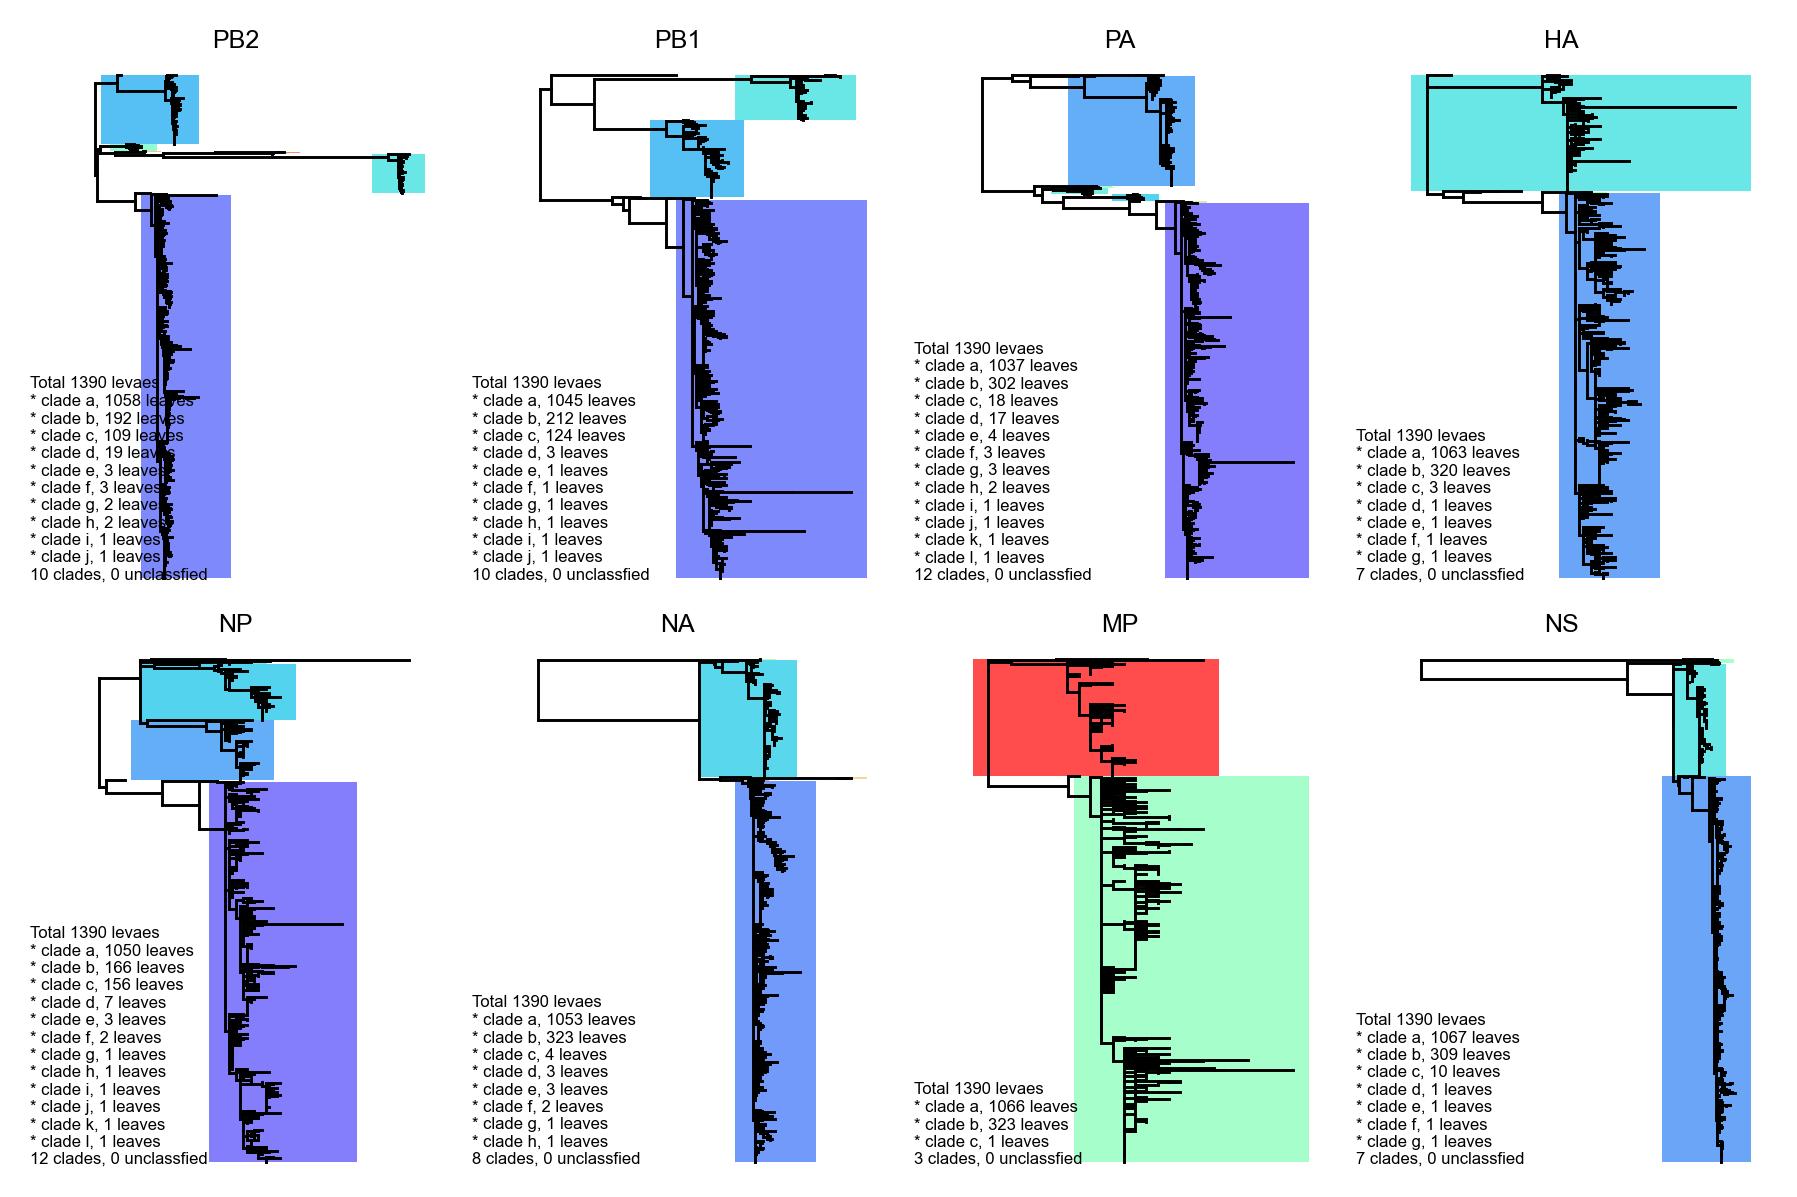

In [389]:
fig, axs = plt.subplots(2, 4, figsize=(6, 4), dpi=300)

axs = np.ravel(axs)

for i, seg in enumerate(segments):
    
    ax = axs[i]
    map_group_results(ax, seg)
    
    ax.set_title(seg, fontsize=6)

plt.tight_layout()

# label group info

In [390]:
index = 'abcdefghijklmnopq'

# seg2group = {}
isl2group = defaultdict(dict)

for seg, pct in final_thr.items():
    
    print(seg, end=', ')

    tree, mpd_l = tree_dict[seg]
    pct = final_thr[seg]
    crit_mpd = np.quantile(np.array(mpd_l), 1-pct/100)
    monophyletic_clades = find_monophyletic_clades(tree, crit_mpd)
    monophyletic_clades = sorted(monophyletic_clades, key=lambda x: len(x), reverse=True)
    
    doc = generate_text_string(monophyletic_clades)
    print(doc + '\n')
    
    ct = 0
    for monophyletic_clade in monophyletic_clades:
        # if len(monophyletic_clade) == 1:
        #     for leave in monophyletic_clade:
        #         seg2group[leave] = 'x'
        #     continue
        for leave in monophyletic_clade:
            isl2group[leave][seg] = index[ct]
        ct += 1
    

PB2, Total 1390 levaes
* clade a, 1058 leaves
* clade b, 192 leaves
* clade c, 109 leaves
* clade d, 19 leaves
* clade e, 3 leaves
* clade f, 3 leaves
* clade g, 2 leaves
* clade h, 2 leaves
* clade i, 1 leaves
* clade j, 1 leaves
10 clades, 0 unclassfied

PB1, Total 1390 levaes
* clade a, 1045 leaves
* clade b, 212 leaves
* clade c, 124 leaves
* clade d, 3 leaves
* clade e, 1 leaves
* clade f, 1 leaves
* clade g, 1 leaves
* clade h, 1 leaves
* clade i, 1 leaves
* clade j, 1 leaves
10 clades, 0 unclassfied

PA, Total 1390 levaes
* clade a, 1037 leaves
* clade b, 302 leaves
* clade c, 18 leaves
* clade d, 17 leaves
* clade e, 4 leaves
* clade f, 3 leaves
* clade g, 3 leaves
* clade h, 2 leaves
* clade i, 1 leaves
* clade j, 1 leaves
* clade k, 1 leaves
* clade l, 1 leaves
12 clades, 0 unclassfied

HA, Total 1390 levaes
* clade a, 1063 leaves
* clade b, 320 leaves
* clade c, 3 leaves
* clade d, 1 leaves
* clade e, 1 leaves
* clade f, 1 leaves
* clade g, 1 leaves
7 clades, 0 unclassfied



## group results

In [10]:
seq_dict = seq_info.set_index('Segment_Id')['Align_sequences'].to_dict()

In [367]:
# final_thr = {'PB2': 1.5, 'PB1': 1.4, 'PA': 1.9, 'HA': 0.7, 'NP': 1.2, 'NA': 1.1, 'MP': 1.0, 'NS': 1.1}
final_thr = {'PB2': 1.5, 'PB1': 1.4, 'PA': 1.9, 'HA': 0.7, 'NP': 1.2, 'NA': 1.1, 'MP': 1.0, 'NS': 0.6}
index = 'abcdefghijklmnopq'

group_res = defaultdict(dict)

for seg, pct in final_thr.items():

    tree, mpd_l = tree_dict[seg]
    pct = final_thr[seg]
    crit_mpd = np.quantile(np.array(mpd_l), 1-pct/100)
    monophyletic_clades = find_monophyletic_clades(tree, crit_mpd)
    
    monophyletic_clades = sorted(monophyletic_clades, key=lambda x: len(x), reverse=True)

    for i, monophyletic_clade in enumerate(monophyletic_clades):
        if len(monophyletic_clade) > 1:
            group_res[seg][index[i]] = monophyletic_clade


In [368]:
def cal_mean_distance(pairs):
    
    distance_v = []
    for a, b in pairs:
        num_sites = 0
        mismatch = 0
        for i, j in zip(seq_dict[a], seq_dict[b]):
            if i == '-' or j == '-':
                continue
            else:
                num_sites += 1
                if i != j:
                    mismatch += 1
        distance_v.append(mismatch/num_sites)
        
    return np.mean(distance_v)

In [369]:
def cal_group_distance(seg):
    
    tmp = group_res[seg]
    res_distance = []
    
    for k, v in tmp.items():
        within = itertools.combinations(v, 2)
        dist = cal_mean_distance(within)
        res_distance.append([seg, k, k, dist])
        print(seg, k, k, dist)

    for k1, k2 in itertools.combinations(tmp.keys(), 2):
        between = itertools.product(tmp[k1], tmp[k2])
        dist = cal_mean_distance(between)
        res_distance.append([seg, k1, k2, dist])
        print(seg, k1, k2, dist)
    
    return res_distance

In [370]:
with Pool(8) as p:
    res = p.map(cal_group_distance, segments)
    p.close()
    p.join()


KeyError: 'EPI_ISL_5865550'

In [ ]:
dist = pd.DataFrame([x_i for x in res for x_i in x], columns=['seg', 'from', 'to', 'dist'])
dist['type'] = dist.apply(lambda x: 'within' if x['from'] == x['to'] else 'between', axis=1)
dist

In [ ]:
g = sns.stripplot(data=dist, x='dist', y='seg', hue='type',jitter=.3,dodge=False)
g.set(xlabel='Distance', ylabel='Segment')
plt.savefig('Sfig7.pdf')

## annotation genotype based on group info

In [ ]:
seq_info = seq_info[seq_info.Isolate_Id.isin(n8_set_2019.Isolate_Id)].copy()
seq_info['group'] = seq_info.apply(lambda x: isl2group[x['Isolate_Id']][x['Segment_Name']], axis=1)

In [457]:
seq_info.head()

,Isolate_Id,Isolate_Name,Segment_Id,Segment_Name,Sequence,seq_len,count_a,count_c,count_g,count_t,count_other,count_N,count_gap,count_q,count_invalid,Align_sequences,group,group2
8,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846450,HA,atggagaacatagtgcttcttcttgcaatagttagccttgttaaaa...,1704,591,316,393,404,0,0,0,0,0,atggagaacatagtgcttcttcttgcaatagttagccttgttaaaa...,b,b
9,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846445,MP,atgagtcttctaaccgaggtcgaaacgtacgttctctctatcgtcc...,982,270,215,269,228,0,0,0,0,0,atgagtcttctaaccgaggtcgaaacgtacgttctctctatcgtcc...,b,b
10,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846449,NA,atgaatccaaatcagaaaatagtgatcgtcggctccatttcattag...,1413,428,244,372,369,0,0,0,0,0,atgaatccaaatcagaaaatagtgatcgtcggctccatttcattag...,b,b
11,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846443,NP,atggcgtctcaaggcaccaaacgatcttatgaacagatggaaactg...,1497,468,300,413,316,0,0,0,0,0,atggcgtctcaaggcaccaaacgatcttatgaacagatggaaactg...,b,b
12,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846444,NS,atggattccaacactgtgttaagctttcaggtagactgttttcttt...,838,262,159,204,213,0,0,0,0,0,atggattccaacactgtgttaagctttcaggtagactgttttcttt...,b,b


In [480]:
# 缺少group信息,按照相似序列group信息填充

# fill_mode = lambda g: g.fillna(g.agg(lambda x: x.value_counts().index[0]))
# seq_info['group2'] = seq_info.groupby('Align_sequences', group_keys=False)['group'].apply(fill_mode)
# seq_info.head()
def switch_NS_bc(x):
    if x == 'b':
        return 'c'
    elif x == 'c':
        return 'b'
    else:
        return x

seq_info['group2'] = seq_info.apply(lambda x: switch_NS_bc(x['group']) if x['Segment_Name'] == 'NP' else x['group'], axis=1)
seq_info

,Isolate_Id,Isolate_Name,Segment_Id,Segment_Name,Sequence,seq_len,count_a,count_c,count_g,count_t,count_other,count_N,count_gap,count_q,count_invalid,Align_sequences,group,group2
8,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846450,HA,atggagaacatagtgcttcttcttgcaatagttagccttgttaaaa...,1704,591,316,393,404,0,0,0,0,0,atggagaacatagtgcttcttcttgcaatagttagccttgttaaaa...,b,b
9,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846445,MP,atgagtcttctaaccgaggtcgaaacgtacgttctctctatcgtcc...,982,270,215,269,228,0,0,0,0,0,atgagtcttctaaccgaggtcgaaacgtacgttctctctatcgtcc...,b,b
10,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846449,NA,atgaatccaaatcagaaaatagtgatcgtcggctccatttcattag...,1413,428,244,372,369,0,0,0,0,0,atgaatccaaatcagaaaatagtgatcgtcggctccatttcattag...,b,b
11,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846443,NP,atggcgtctcaaggcaccaaacgatcttatgaacagatggaaactg...,1497,468,300,413,316,0,0,0,0,0,atggcgtctcaaggcaccaaacgatcttatgaacagatggaaactg...,b,c
12,EPI_ISL_1009679,A/duck/Korea/H007/2020,EPI1846444,NS,atggattccaacactgtgttaagctttcaggtagactgttttcttt...,838,262,159,204,213,0,0,0,0,0,atggattccaacactgtgttaagctttcaggtagactgttttcttt...,b,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34755,EPI_ISL_996003,A/chicken/Northern_Ireland/2021-000067_21VIR11...,EPI1846306,NP,agcaaaagcagggtagataatcactcactgagtgacatcaacatca...,1565,497,315,421,332,0,0,0,0,0,atggcgtctcaaggcaccaaacgatcttatgaacagatggaaactg...,a,a
34756,EPI_ISL_996003,A/chicken/Northern_Ireland/2021-000067_21VIR11...,EPI1846309,NS,agcaaaagcagggtgacaaaaacataatggatcccaacactatgtt...,890,287,172,210,221,0,0,0,0,0,atggatcccaacactatgttaagctttcaggtagactgttttcttt...,a,a
34757,EPI_ISL_996003,A/chicken/Northern_Ireland/2021-000067_21VIR11...,EPI1846304,PA,agcraaagcaggtactgatccaaaatggaagactttgtgcgacaat...,2233,740,449,532,511,0,0,0,0,1,atggaagactttgtgcgacaatgcttcaatccaatgattgtcgagc...,a,a
34758,EPI_ISL_996003,A/chicken/Northern_Ireland/2021-000067_21VIR11...,EPI1846303,PB1,agcgaaagcaggcaaactatttgaatggatgtcaatccgactttac...,2341,802,465,556,518,0,0,0,0,0,atggatgtcaatccgactttacttttcttaaaagtgccagcgcaaa...,a,a


# genotype info

In [481]:
genotype = pd.pivot(data=seq_info, index='Isolate_Id', columns='Segment_Name', values='group2')
genotype = genotype.dropna(how='any').reindex(columns=segments)
genotype['genotype'] = genotype.apply(lambda x: ''.join(x.to_list()) ,axis=1)
# genotype.head()

In [482]:
genotype.to_csv('./data/01_h5n8_after2019/genotype.csv', sep='\t')

In [95]:
genotype = pd.read_csv('./data/01_h5n8_after2019/genotype.csv', sep='\t', index_col=0)
genotype.head()

,PB2,PB1,PA,HA,NP,NA,MP,NS,genotype
Isolate_Id,,,,,,,,,
EPI_ISL_1009679,b,b,b,b,c,b,b,b,bbbbcbbb
EPI_ISL_1009680,a,a,a,a,a,a,a,a,aaaaaaaa
EPI_ISL_1009681,c,c,b,b,c,b,b,b,ccbbcbbb
EPI_ISL_1009682,a,a,a,a,a,a,a,a,aaaaaaaa
EPI_ISL_1009683,a,a,a,a,a,a,a,a,aaaaaaaa


In [96]:
isl_with_genotype = genotype.index.to_list()
HA_with_genotype = isl_info.loc[isl_info.Isolate_Id.isin(isl_with_genotype), 'HA'].to_list()

isl2genotype = genotype['genotype'].to_dict()
genotype_l = genotype['genotype'].unique().tolist()
num_genotypes = len(genotype_l)

print(f"Total number of genotypes: {num_genotypes}")
print(', '.join(genotype_l))

for k,v in genotype['genotype'].value_counts().items():
    print(f"\tgenotype: {k:<10}  number: {v:4}")

Total number of genotypes: 27
bbbbcbbb, aaaaaaaa, ccbbcbbb, bbbbbbbb, dccbcbbc, dbcbcbbb, aaaaafaa, abdaaaaa, aaaaaaae, aafaaeaa, aaeaaaaa, aaaadaaa, fdgceaaa, jjlglgca, aaaaahaa, aafageaa, gchafaaa, aaaaacaa, gchafaad, hhidibba, hijejbba, aadaaaaa, igkfkbba, aaaaaaaf, eceabdaa, bfbbhbbg, debbcbbb
	genotype: aaaaaaaa    number: 1021
	genotype: bbbbbbbb    number:  153
	genotype: ccbbcbbb    number:  109
	genotype: bbbbcbbb    number:   38
	genotype: abdaaaaa    number:   13
	genotype: dccbcbbc    number:   10
	genotype: dbcbcbbb    number:    8
	genotype: aaaadaaa    number:    7
	genotype: aaaaacaa    number:    4
	genotype: aadaaaaa    number:    4
	genotype: fdgceaaa    number:    3
	genotype: eceabdaa    number:    3
	genotype: aafaaeaa    number:    2
	genotype: aaaaafaa    number:    2
	genotype: hhidibba    number:    1
	genotype: aaaaaaaf    number:    1
	genotype: igkfkbba    number:    1
	genotype: bfbbhbbg    number:    1
	genotype: hijejbba    number:    1
	genotype: jjlglg

# merge genotype info with isolate meta info

In [98]:
metainfo = pd.merge(isl_info[['Isolate_Id', 'Isolate_Name', 'Collection_Date', 'Location', 'Host', 'Domestic_Status']], genotype, left_on='Isolate_Id', right_index=True, how='right')#.set_index('Isolate_Id')

metainfo['date'] = pd.to_datetime(metainfo.Collection_Date)
metainfo['host'] = metainfo.Isolate_Name.str.split('/').str.get(1)
metainfo['region'] = metainfo.Location.str.split(' / ').str.get(0)
metainfo['country'] = metainfo.Location.str.split(' / ').str.get(1)
metainfo['province'] = metainfo.Location.str.split(' / ').str.get(2)
metainfo['city'] = metainfo.Location.str.split(' / ').str.get(3)

# metainfo = metainfo.fillna('')
metainfo.sort_values(by='date').head(5)

,Isolate_Id,Isolate_Name,Collection_Date,Location,Host,Domestic_Status,PB2,PB1,PA,HA,...,NA,MP,NS,genotype,date,host,region,country,province,city
817,EPI_ISL_525439,A/laying_hen/Poland/002/2020,2020-01-01,Europe / Poland / Greater Poland Voivodeship,Gallus gallus domesticus,Domestic,b,b,b,b,...,b,b,b,bbbbbbbb,2020-01-01,laying_hen,Europe,Poland,Greater Poland Voivodeship,NaN
818,EPI_ISL_525441,A/chicken/Poland/004/2020,2020-01-02,Europe / Poland / Lublin Voivodeship,Gallus gallus domesticus,Domestic,b,b,b,b,...,b,b,b,bbbbbbbb,2020-01-02,chicken,Europe,Poland,Lublin Voivodeship,NaN
819,EPI_ISL_525440,A/chicken/Poland/003/2020,2020-01-02,Europe / Poland / Lublin Voivodeship,Gallus gallus domesticus,Domestic,b,b,b,b,...,b,b,b,bbbbbbbb,2020-01-02,chicken,Europe,Poland,Lublin Voivodeship,NaN
820,EPI_ISL_405813,A/hawk/Poland/003/2020,2020-01-06,Europe / Poland / Lublin Voivodeship,Wild bird,Wild,b,b,b,b,...,b,b,b,bbbbbbbb,2020-01-06,hawk,Europe,Poland,Lublin Voivodeship,NaN
821,EPI_ISL_525442,A/turkey/Poland/027/2020,2020-01-09,Europe / Poland,Turkey,,b,b,b,b,...,b,b,b,bbbbbbbb,2020-01-09,turkey,Europe,Poland,NaN,NaN


In [99]:
genotype_sort_by_date = metainfo.groupby('genotype')['date'].min().sort_values().index

In [100]:
for genotype_i in genotype_sort_by_date:
    
    if genotype_i[3] not in ['a', 'b']:
        continue
        
    df_i = metainfo.query("genotype == @genotype_i").sort_values(by='date')
    start = df_i.date.min().strftime("%Y-%m-%d")
    end = df_i.date.max().strftime("%Y-%m-%d")
    print(f"{genotype_i} ({df_i.shape[0]}) {start} ~ {end}")

bbbbbbbb (153) 2020-01-01 ~ 2021-01-28
bfbbhbbg (1) 2020-04-01 ~ 2020-04-01
aaaaaaaa (1021) 2020-07-31 ~ 2022-03-01
aadaaaaa (4) 2020-08-17 ~ 2020-08-17
aaeaaaaa (1) 2020-08-29 ~ 2020-08-29
eceabdaa (3) 2020-09-20 ~ 2020-09-20
ccbbcbbb (109) 2020-11-23 ~ 2021-03-13
dccbcbbc (10) 2020-12-02 ~ 2020-12-28
debbcbbb (1) 2020-12-11 ~ 2020-12-11
dbcbcbbb (8) 2020-12-11 ~ 2021-02-24
aaaaacaa (4) 2020-12-16 ~ 2021-03-02
bbbbcbbb (38) 2020-12-18 ~ 2021-03-03
aaaaafaa (2) 2021-01-04 ~ 2021-02-19
gchafaaa (1) 2021-01-22 ~ 2021-01-22
abdaaaaa (13) 2021-02-16 ~ 2021-05-21
aafaaeaa (2) 2021-02-24 ~ 2021-03-02
aaaadaaa (7) 2021-02-26 ~ 2021-08-19
gchafaad (1) 2021-03-02 ~ 2021-03-02
aafageaa (1) 2021-04-06 ~ 2021-04-06
aaaaahaa (1) 2021-05-21 ~ 2021-05-21
aaaaaaaf (1) 2021-07-01 ~ 2021-07-01
aaaaaaae (1) 2021-12-01 ~ 2021-12-01


In [20]:
# bbbbbbbb (153) 2020-01-01 ~ 2021-01-28 G0
# bbbbcbbb (38) 2020-12-18 ~ 2021-03-03 G0R1
# ccbbcbbb (109) 2020-11-23 ~ 2021-03-13 G0R2
# dbcbcbbb (8) 2020-12-11 ~ 2021-02-24 G0R3
# dccbcbbc (10) 2020-12-02 ~ 2020-12-28 G0R4


# bfbbhbbg (1) 2020-04-01 ~ 2020-04-01 G0other
# debbcbbb (1) 2020-12-11 ~ 2020-12-11 G0other

# aaaaaaaa (1021) 2020-07-31 ~ 2022-03-01 G1
# aaaaacaa (4) 2020-12-16 ~ 2021-03-02 G1R1
# aaaadaaa (7) 2021-02-26 ~ 2021-08-19 G1R2
# aaaaafaa (2) 2021-01-04 ~ 2021-02-19 G1R3
# aafaaeaa (2) 2021-02-24 ~ 2021-03-02 G1R4
# abdaaaaa (13) 2021-02-16 ~ 2021-05-21 G1R5



# aadaaaaa (4) 2020-08-17 ~ 2020-08-17 G1other
# aaeaaaaa (1) 2020-08-29 ~ 2020-08-29 G1other
# eceabdaa (3) 2020-09-20 ~ 2020-09-20 G1other
# gchafaaa (1) 2021-01-22 ~ 2021-01-22 G1other
# gchafaad (1) 2021-03-02 ~ 2021-03-02 G1other
# aafageaa (1) 2021-04-06 ~ 2021-04-06 G1other
# aaaaahaa (1) 2021-05-21 ~ 2021-05-21 G1other
# aaaaaaaf (1) 2021-07-01 ~ 2021-07-01 G1other
# aaaaaaae (1) 2021-12-01 ~ 2021-12-01 G1other

In [136]:
G0_series = ['bbbbbbbb', 'ccbbcbbb', 'dccbcbbc', 'bbbbcbbb', 'dbcbcbbb']
G0_other = ['bfbbhbbg', 'debbcbbb']

G1_series = ['aaaaaaaa', 'aaaaacaa', 'aaaaafaa', 'abdaaaaa', 'aafaaeaa', 'aaaadaaa']
G1_other = ['aadaaaaa','aaeaaaaa','eceacdaa','gchafaaa','gchafaad','aafageaa', 'aaaaahaa', 'aaaaaaaf', 'aaaaaaae']


genotype_covert = {
    'bbbbbbbb': 'G0', 'bbbbcbbb': 'G0R1', 'ccbbcbbb': 'G0R2', 'dbcbcbbb': 'G0R3', 'dccbcbbc': 'G0R4', 
    'aaaaaaaa': 'G1', 'aaaaacaa': 'G1R1', 'aaaadaaa': 'G1R2', 'aaaaafaa': 'G1R3', 'aafaaeaa': 'G1R4', 'abdaaaaa': 'G1R5',
    'bfbbhbbg': 'G0other', 'debbcbbb': 'G0other',
    'aadaaaaa': 'G1other', 'aaeaaaaa': 'G1other','eceacdaa': 'G1other','gchafaaa': 'G1other','aafageaa': 'G1other','aaaaahaa': 'G1other', 'aaaaaaaf': 'G1other', 'aaaaaaae': 'G1other'
}

metainfo['genotype2'] = metainfo['genotype'].map(lambda x: genotype_covert.get(x, 'other'))


G0_series = ['G0','G0R1','G0R2','G0R3','G0R4','G0other']
G1_series = ['G1','G1R1','G1R2','G1R3','G1R4', 'G1R5', 'G1other']

G0_colors = sns.color_palette("Oranges_r", len(G0_series)+3, as_cmap=True)
G1_colors = sns.color_palette("Blues_r", len(G1_series)+1, as_cmap=True)

genotype_cmap = dict(zip(G0_series+G1_series, 
                         [to_hex(G0_colors((i+3)/(len(G0_series)+3))) for i in range(len(G0_series))]
                         + 
                         [to_hex(G1_colors((i+1)/(len(G1_series)+1))) for i in range(len(G1_series))]
                        )
                    )

In [137]:
metainfo['genotype2'] = metainfo.genotype.map(lambda x: genotype_covert.get(x, 'other'))
metainfo.genotype2.value_counts()

G1         1021
G0          153
G0R2        109
G0R1         38
G1R5         13
other        11
G0R4         10
G1other      10
G0R3          8
G1R2          7
G1R1          4
G1R3          2
G1R4          2
G0other       2
Name: genotype2, dtype: int64

In [138]:
genotype_sort_by_date = metainfo.groupby('genotype2')['date'].min().sort_values().index

for genotype_i in genotype_sort_by_date:

    df_i = metainfo.query("genotype2 == @genotype_i").sort_values(by='date')
    start = df_i.date.min().strftime("%Y-%m-%d")
    end = df_i.date.max().strftime("%Y-%m-%d")
    print(f"{genotype_i} ({df_i.shape[0]}) {start} ~ {end}")

G0 (153) 2020-01-01 ~ 2021-01-28
other (11) 2020-02-21 ~ 2021-03-03
G0other (2) 2020-04-01 ~ 2020-12-11
G1 (1021) 2020-07-31 ~ 2022-03-01
G1other (10) 2020-08-17 ~ 2021-12-01
G0R2 (109) 2020-11-23 ~ 2021-03-13
G0R4 (10) 2020-12-02 ~ 2020-12-28
G0R3 (8) 2020-12-11 ~ 2021-02-24
G1R1 (4) 2020-12-16 ~ 2021-03-02
G0R1 (38) 2020-12-18 ~ 2021-03-03
G1R3 (2) 2021-01-04 ~ 2021-02-19
G1R5 (13) 2021-02-16 ~ 2021-05-21
G1R4 (2) 2021-02-24 ~ 2021-03-02
G1R2 (7) 2021-02-26 ~ 2021-08-19


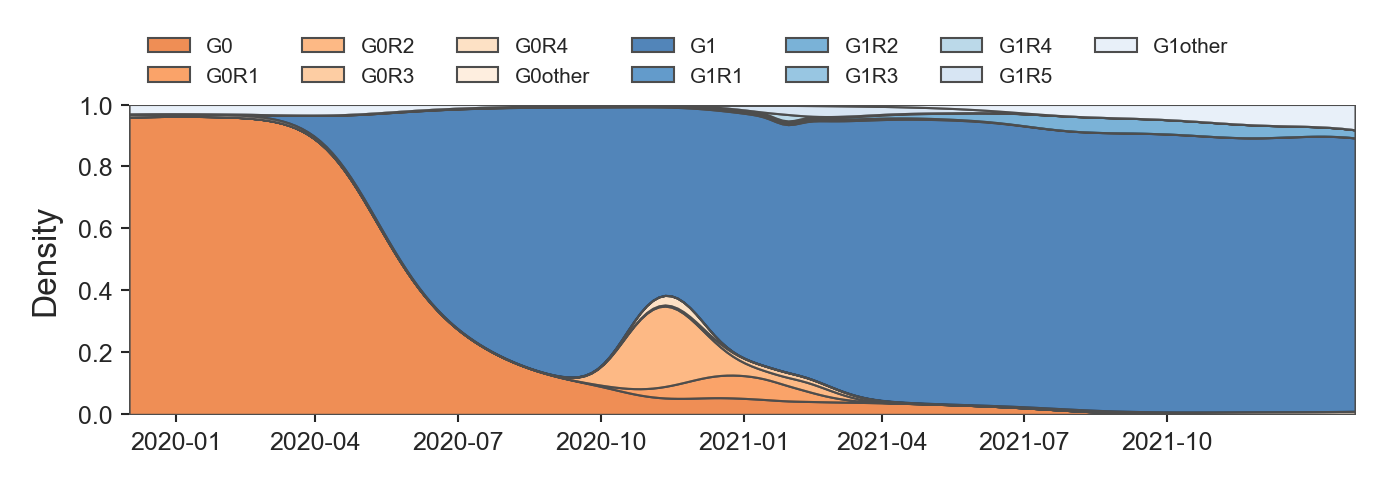

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 1.5), dpi=300, constrained_layout=True)

sns.kdeplot(
    ax=ax, data=metainfo, x="date", 
    hue="genotype2", hue_order=(G0_series+G1_series)[::-1],
    multiple="fill", bw_adjust=2, clip=(0, None), cut=0, common_norm=True, palette=genotype_cmap,
    alpha=.7, linewidth=.5, edgecolor=".3", legend=True,
    warn_singular=False
)

sns.despine(top=True, right=True, left=True, bottom=True)

ax.legend(
    labels=G0_series+G1_series,
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=7, fontsize=5, title=''
)

ax.set_xlabel('')
ax.set_ylabel('Density', fontdict={'fontsize': 8})

ax.xaxis.set_major_formatter(mdate.DateFormatter("%Y-%m"))
plt.xticks(pd.date_range('2020-01-01', '2022-1-01', freq='3M'))

for label in ax.get_xticklabels():
    label.set(rotation=0)

ax.grid(False)


plt.show()

# draw HA tree with genotype composition

In [141]:
# ha_ = ['EPI1896395','EPI1807331','EPI1807307','EPI1807347','EPI1815191',]
# isl_info.query("HA in @ha_")

In [142]:
tree.leaf_nodes()[0].taxon.label

'EPI ISL 9594306'

In [143]:
segment = "HA"
tree_file = f'./data/01_h5n8_after2019/treetime_HA/divergence_tree.nexus'
tree = dendropy.Tree.get(path=tree_file, schema='nexus', extract_comment_metadata=True)
tree.resolve_polytomies()
print(len(tree.leaf_nodes()))

tree.prune_taxa([l.taxon for l in tree.leaf_nodes() if l.edge_length==0])

tree.prune_taxa_with_labels(['EPI ISL 4061715'])

print(len(tree.leaf_nodes()))
# tree.reroot_at_midpoint(update_bipartitions=False)
# tree.ladderize(ascending=False)

# leaf_without_geno = [leaf.taxon for leaf in tree.leaf_nodes() if seg2isl[leaf.taxon.label] not in isl_with_genotype]


treeString = tree.as_string(schema='newick', suppress_rooting=True, suppress_annotations=True, annotations_as_nhx=False)

ll=bt.loadNewick(StringIO(treeString),tip_regex='_([0-9\-]+)$', absoluteTime=False)
# ll.renameTips(isl2genotype)

1390
465


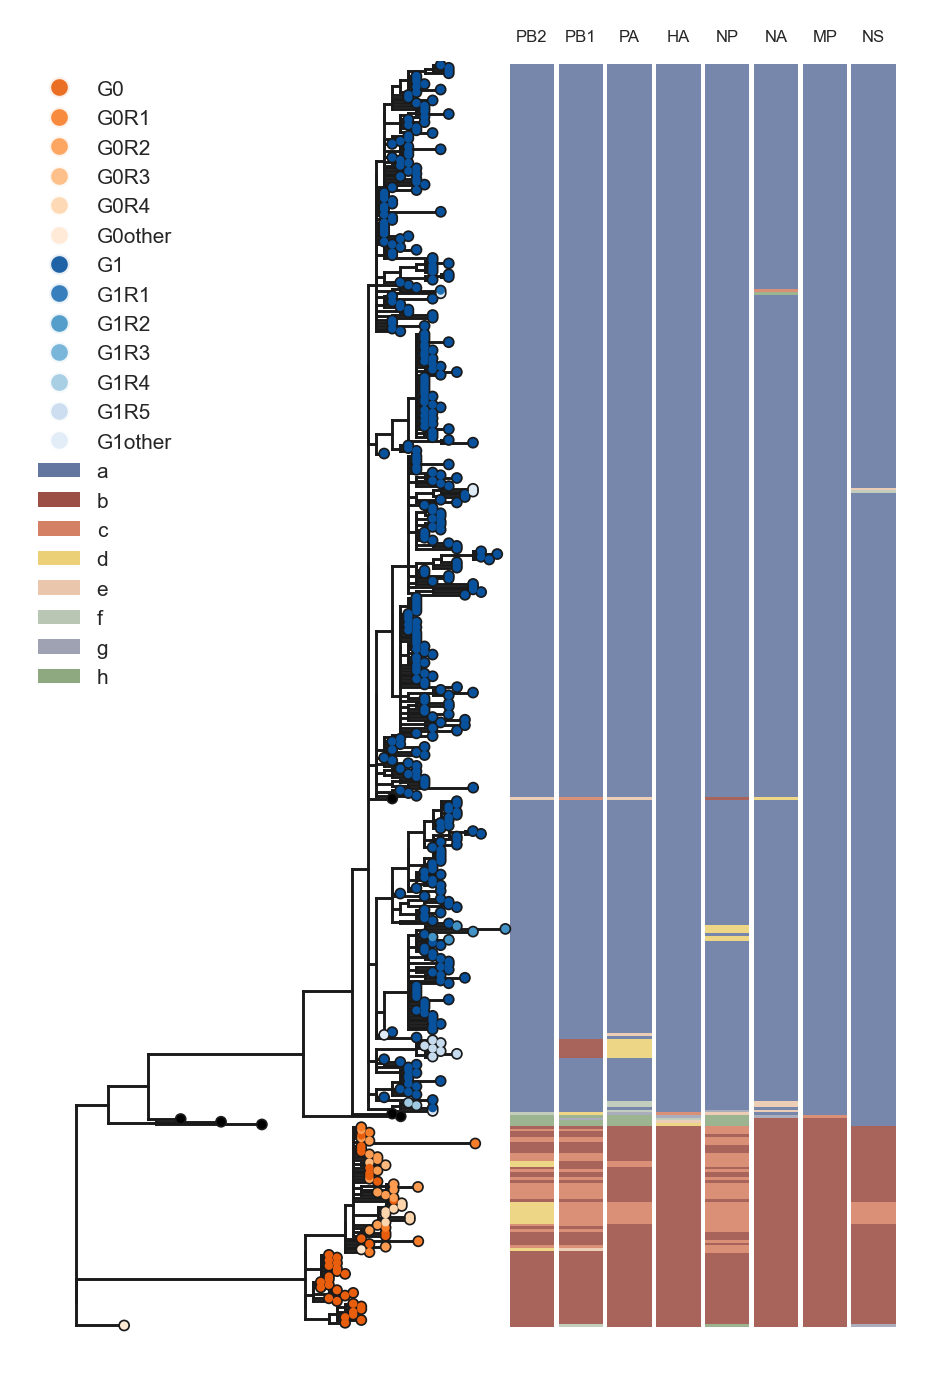

In [144]:
# scale = 10
index = 'abcdefghijklmnopq'

for leaf in ll.getExternal():
    genotype = isl2genotype.get(leaf.name, None)
    leaf.traits['genotype'] = genotype
    leaf.traits['genotype2'] = genotype_covert.get(genotype, 'other')

color_seg = ['#3C5488', '#832316', '#ca613d', '#e8c555', '#e4b897', '#a9b8a2', '#878b9f', '#729461', '#729461', '#729461', '#729461', '#729461', '#729461', '#729461', '#729461']


fig = plt.figure(figsize=(3, 4.5), facecolor='w', dpi=300, constrained_layout=True)

with plt.rc_context({'font.family': 'Arial', 'font.size': 8, 'hatch.linewidth': .5, 'lines.linewidth': .5, 'patch.linewidth': .5,}):

    ax = fig.add_subplot(1,1,1)

    y_attr=lambda k: -k.y
    color_func=lambda k: genotype_cmap.get(k.traits['genotype2'], 'black')

    ll.plotTree(ax, y_attr=y_attr, width=.7)
    ll.plotPoints(ax,target=lambda k: k.is_leaf(), y_attr=y_attr, colour=color_func, size=4, zorder=100)

    w = ll.treeHeight/10
    skip = w / 10
    h = 1

    for leaf in ll.getExternal():
        y = leaf.y
        genotype_ = leaf.traits['genotype']

        if not genotype_:
            continue

        for s in range(8):
            seg_group_index = index.index(genotype_[s])
            base=ll.treeHeight + skip ## where reassortment indicator boxes begin
            rect=plt.Rectangle(
                (base+s*(w+skip),-leaf.y-h/2),
                w,
                h,
                facecolor=color_seg[seg_group_index],
                edgecolor=color_seg[seg_group_index],
                lw=.0, 
                alpha=.7
            )
            ax.add_patch(rect) ## add rectangle to plot            


    for i, seg in enumerate(segments):
        ax.text(base+i*(w+skip)+w/2, 10, seg, fontsize=4, horizontalalignment='center', verticalalignment='center', rotation=0)

        
    handles = []
    for k, v in genotype_cmap.items():
        handles.append(Line2D([0], [0], marker='o', markerfacecolor=v, lw=0, label=k, alpha=.9, markersize=5, color='w'))
    
    for group, color in zip('abcdefgh', color_seg[0:8]):
        handles.append(mpatches.Patch(facecolor=color, label=group, alpha=.8, edgecolor='1', linewidth=0))
        
    ax.legend(handles=handles, frameon=False, fontsize=5, loc='upper left', bbox_to_anchor=(-.05, 1))



    ax.set_xlim(0, ll.treeHeight+w*9)
    ax.set_xticks([])
    ax.set_yticklabels([])

    ax.set_ylim(-10-ll.ySpan, 1) ## set y limits
    ax.set_yticks([])
    ax.set_yticklabels([])

    [ax.spines[loc].set_visible(False) for loc in ax.spines]

    # plt.savefig('./results/fig3a.pdf')
    plt.show()

# genotype dynamic

In [209]:
metainfo_filter = metainfo[metainfo.genotype2.isin(G0_series+G1_series)]
metainfo_filter = metainfo_filter.sort_values(by='date')
metainfo_filter = metainfo_filter[metainfo_filter.date <= datetime(2021, 12, 31)]#.reset_index()
# metainfo_filter = metainfo
metainfo_filter.head()

,Isolate_Id,Isolate_Name,Collection_Date,Location,Host,Domestic_Status,PB2,PB1,PA,HA,...,MP,NS,genotype,date,host,region,country,province,city,genotype2
817,EPI_ISL_525439,A/laying_hen/Poland/002/2020,2020-01-01,Europe / Poland / Greater Poland Voivodeship,Gallus gallus domesticus,Domestic,b,b,b,b,...,b,b,bbbbbbbb,2020-01-01,laying_hen,Europe,Poland,Greater Poland Voivodeship,NaN,G0
819,EPI_ISL_525440,A/chicken/Poland/003/2020,2020-01-02,Europe / Poland / Lublin Voivodeship,Gallus gallus domesticus,Domestic,b,b,b,b,...,b,b,bbbbbbbb,2020-01-02,chicken,Europe,Poland,Lublin Voivodeship,NaN,G0
818,EPI_ISL_525441,A/chicken/Poland/004/2020,2020-01-02,Europe / Poland / Lublin Voivodeship,Gallus gallus domesticus,Domestic,b,b,b,b,...,b,b,bbbbbbbb,2020-01-02,chicken,Europe,Poland,Lublin Voivodeship,NaN,G0
820,EPI_ISL_405813,A/hawk/Poland/003/2020,2020-01-06,Europe / Poland / Lublin Voivodeship,Wild bird,Wild,b,b,b,b,...,b,b,bbbbbbbb,2020-01-06,hawk,Europe,Poland,Lublin Voivodeship,NaN,G0
822,EPI_ISL_419220,A/turkey/Hungary/1020_20VIR749-1/2020,2020-01-09,Europe / Hungary,Turkey,,b,b,b,b,...,b,b,bbbbbbbb,2020-01-09,turkey,Europe,Hungary,NaN,NaN,G0


In [210]:
metainfo_filter.date.max()

Timestamp('2021-12-01 00:00:00')

In [211]:
host_code = pd.read_csv('./data/code_host.csv', sep='\t')
host_code.head()

,Host,host,host2
0,Accipiter gentilis,northern goshawk,Other
1,Aix galericulata,Mandarin duck,Waterfowl
2,Aix galericulata,mandarin duck,Waterfowl
3,Anas acuta,pintail,Waterfowl
4,Anas clypeata,northern shoveler,Waterfowl


In [212]:
loc_code = pd.read_csv('./data/code_location.csv', sep='\t')
loc_code.head()

,Region,Country,Province,Subregion,Latitude,Longitude
0,Africa,Cameroon,NaN,Central_Africa,7.37,12.35
1,Africa,"Congo, the Democatic Republic of",NaN,Central_Africa,-4.04,21.76
2,Asia,Kazakhstan,Akmola,Central_Asia,51.92,69.41
3,Asia,Kazakhstan,Almaty Province,Central_Asia,45.01,78.42
4,Asia,Kazakhstan,Kostanay,Central_Asia,53.22,63.64


In [213]:
tmp = pd.merge(metainfo_filter, loc_code, left_on=['region', 'country', 'province'], right_on=['Region', 'Country', 'Province'], how='left')
metainfo_filter2 = pd.merge(tmp, host_code, left_on=['Host', 'host'], right_on=['Host', 'host'], how='left')
metainfo_filter2.drop(columns=['Location','Collection_Date', 'host', 'Host', 'region', 'country', 'province'], inplace=True)

In [214]:
metainfo_filter2 = metainfo_filter2[metainfo_filter2.Isolate_Id!='EPI_ISL_7623043']

In [215]:
metainfo_filter2.date.max()

Timestamp('2021-12-01 00:00:00')

In [216]:
metainfo_filter2.head()

,Isolate_Id,Isolate_Name,Domestic_Status,PB2,PB1,PA,HA,NP,NA,MP,...,date,city,genotype2,Region,Country,Province,Subregion,Latitude,Longitude,host2
0,EPI_ISL_525439,A/laying_hen/Poland/002/2020,Domestic,b,b,b,b,b,b,b,...,2020-01-01,NaN,G0,Europe,Poland,Greater Poland Voivodeship,Central_East_Europe,52.28,17.35,Dom-gal
1,EPI_ISL_525440,A/chicken/Poland/003/2020,Domestic,b,b,b,b,b,b,b,...,2020-01-02,NaN,G0,Europe,Poland,Lublin Voivodeship,Central_East_Europe,51.25,23.10,Dom-gal
2,EPI_ISL_525441,A/chicken/Poland/004/2020,Domestic,b,b,b,b,b,b,b,...,2020-01-02,NaN,G0,Europe,Poland,Lublin Voivodeship,Central_East_Europe,51.25,23.10,Dom-gal
3,EPI_ISL_405813,A/hawk/Poland/003/2020,Wild,b,b,b,b,b,b,b,...,2020-01-06,NaN,G0,Europe,Poland,Lublin Voivodeship,Central_East_Europe,51.25,23.10,Other
4,EPI_ISL_419220,A/turkey/Hungary/1020_20VIR749-1/2020,,b,b,b,b,b,b,b,...,2020-01-09,NaN,G0,Europe,Hungary,NaN,Central_East_Europe,47.16,19.50,Dom-gal


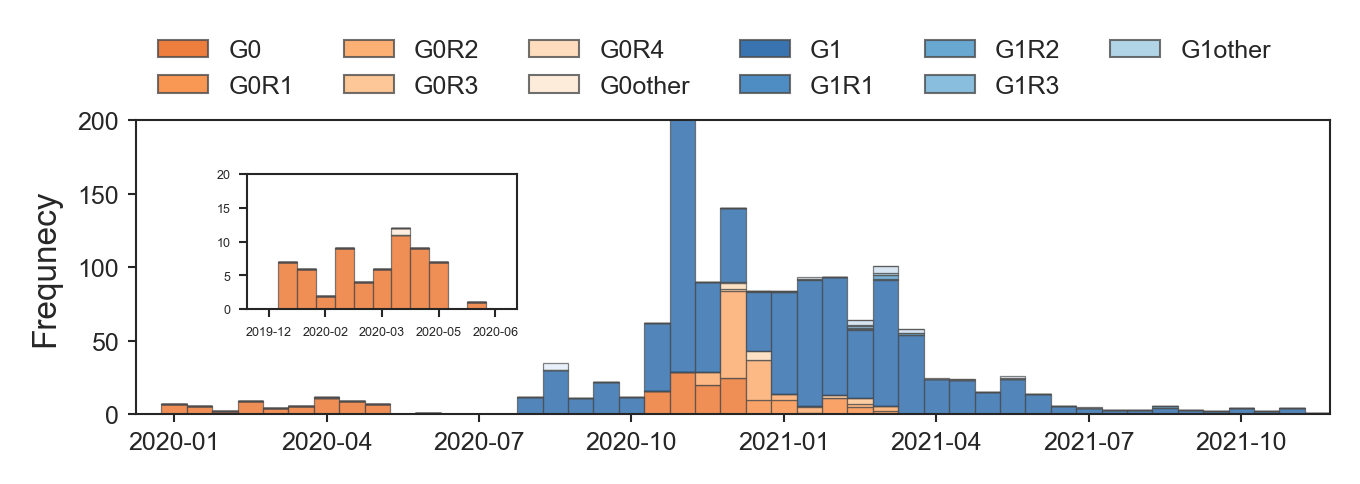

In [217]:
sns.set_theme(style="ticks")
sns.set_context({
    'xtick.labelsize': 6, 'xtick.major.width': .5, 'xtick.major.size': 2, 'xtick.major.pad': 2,
    'ytick.labelsize': 6, 'ytick.major.width': .5, 'ytick.major.size': 2, 'ytick.major.pad': 2,
    'font.size': 8., 'axes.labelsize': 8.0, 'axes.linewidth': .5})



bins = pd.date_range('2019-12-01', '2021-11-30', freq='SM')
labels = bins[1:].map(lambda x: x.strftime('%Y-%m-%d'))

hist = {}
for genotype_i in G1_series+G0_series:
    df_i = metainfo_filter2.query("genotype2 == @genotype_i")
    hist_i, _ = np.histogram(df_i['date'], bins=bins)
    hist[genotype_i] = hist_i

    

fig, ax = plt.subplots(figsize=(4.5, 1.5), dpi=300, constrained_layout=True)

bottom = np.zeros(len(labels))
for genotype_i in (G0_series+G1_series):
    hist_i = hist[genotype_i]
    ax.bar(labels, hist_i, bottom=bottom, label=genotype_i, width=1, color=genotype_cmap[genotype_i], alpha=.7, edgecolor='.3', linewidth=0.3)
    bottom = bottom + hist_i
        
x_ticks = np.arange(1, len(labels), 6)
x_ticklabels = [x[0:7] for x in labels[x_ticks]]
ax.set(xticks=x_ticks, xticklabels=x_ticklabels)


inset_ax = fig.add_axes([0.17, .35, .2, .3])
bottom = np.zeros(len(labels[:13]))
for genotype_i in G0_series+G1_series:
    hist_i = hist[genotype_i][:13]
    inset_ax.bar(labels[:13], hist_i, bottom=bottom, label=genotype_i, width=1, color=genotype_cmap[genotype_i], alpha=.7, edgecolor='.3', linewidth=0.3)
    bottom = bottom + hist_i
    
x_ticks = np.arange(0, len(labels[:13]), 3)
x_ticklabels = [x[0:7] for x in labels[x_ticks]]
inset_ax.set(xticks=x_ticks, xticklabels=x_ticklabels, ylim=(0, 15))

for label in inset_ax.get_xticklabels():
    label.set(fontsize=3, rotation=0)

inset_ax.set_yticks(np.arange(0, 21, 5))
for label in inset_ax.get_yticklabels():
    label.set(fontsize=3, rotation=0)

ax.set_ylim(0, 200)
ax.set_ylabel("Frequnecy")

handles = [mpatches.Patch(facecolor=color, label=geno, alpha=.8, edgecolor='.3', linewidth=.5) for geno, color in genotype_cmap.items()]
ax.legend(
    handles=handles, 
    labels=['G0', 'G0R1', 'G0R2', 'G0R3', 'G0R4', 'G0other', 'G1', 'G1R1', 'G1R2', 'G1R3', 'G1other'], 
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=6, fontsize=6
)

ax.set_xmargin(0)

# plt.savefig('./results/fig3c.pdf')
# plt.show()
plt.show()

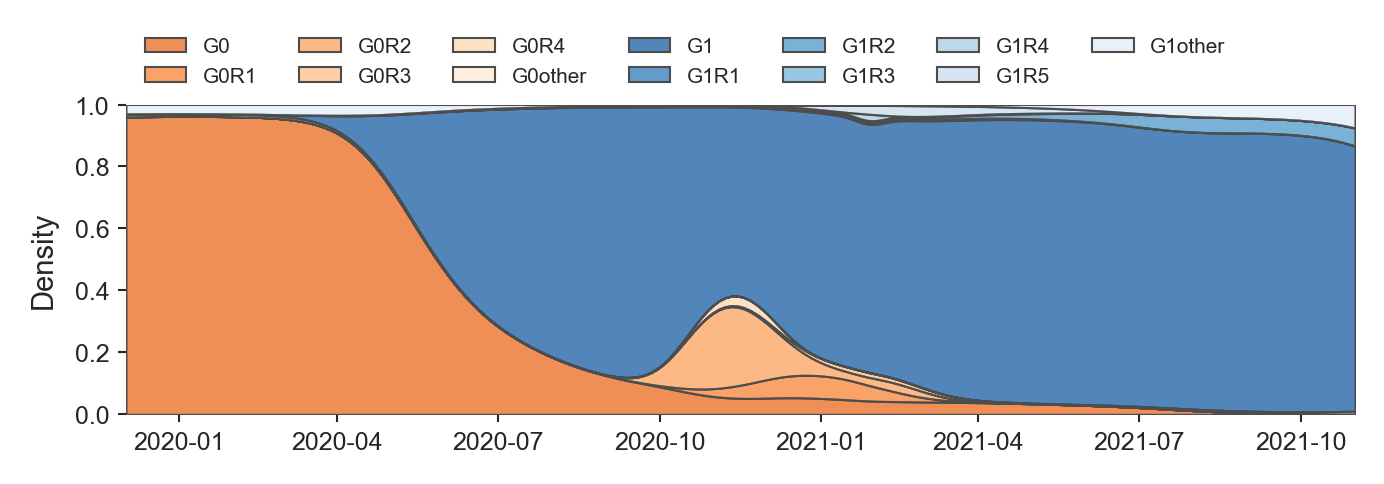

In [218]:
# Plot the distribution of clarity ratings, conditional on carat
sns.set_theme(style="ticks")

sns.set_context({
    'xtick.labelsize': 6, 'xtick.major.width': .5, 'xtick.major.size': 2, 'xtick.major.pad': 2,
    'ytick.labelsize': 6, 'ytick.major.width': .5, 'ytick.major.size': 2, 'ytick.major.pad': 2,
    'font.size': 8., 'axes.labelsize': 8.0, 'axes.linewidth': .5
    })


fig, ax = plt.subplots(1, 1, figsize=(4.5, 1.5), dpi=300, constrained_layout=True)

sns.kdeplot(
    ax=ax, data=metainfo_filter2, x="date", 
    hue="genotype2", hue_order=(G0_series+G1_series)[::-1],
    multiple="fill", bw_adjust=2, clip=(0, None), cut=0, common_norm=True, palette=genotype_cmap,
    alpha=.7, linewidth=.5, edgecolor=".3", legend=True,
    warn_singular=False
)

sns.despine(top=True, right=True, left=True, bottom=True)

ax.legend(
    labels=G0_series+G1_series,
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=7, fontsize=5, title=''
)

ax.set_xlabel('')
ax.set_ylabel('Density', fontdict={'fontsize': 7})

ax.xaxis.set_major_formatter(mdate.DateFormatter("%Y-%m"))
plt.xticks(pd.date_range('2020-01-01', '2021-12-31', freq='3M'))

for label in ax.get_xticklabels():
    label.set(rotation=0)

ax.grid(False)

# plt.tight_layout()

# plt.savefig('./results/fig3d.pdf')

plt.show()

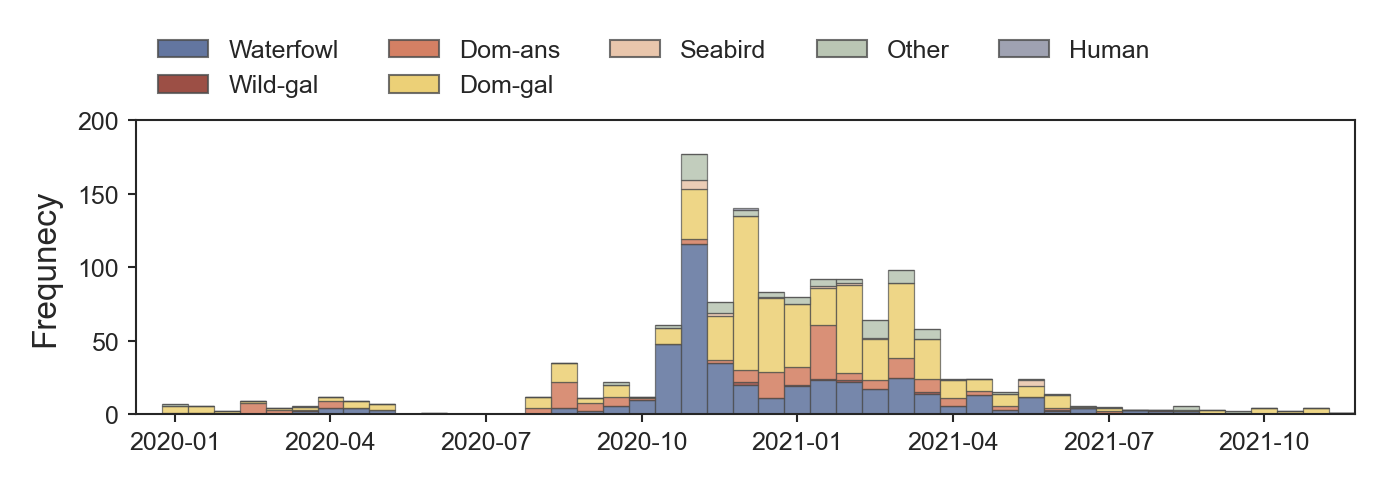

In [219]:
sns.set_theme(style="ticks")
sns.set_context({
    'xtick.labelsize': 6, 'xtick.major.width': .5, 'xtick.major.size': 2, 'xtick.major.pad': 2,
    'ytick.labelsize': 6, 'ytick.major.width': .5, 'ytick.major.size': 2, 'ytick.major.pad': 2,
    'font.size': 8., 'axes.labelsize': 8.0, 'axes.linewidth': .5})


host_l = ['Waterfowl', 'Wild-gal', 'Dom-ans', 'Dom-gal', 'Seabird', 'Other', 'Human']
color_seg = ['#3C5488', '#832316', '#ca613d', '#e8c555', '#e4b897', '#a9b8a2', '#878b9f']
host_cmap = dict(zip(host_l, color_seg))


hist = {}
bins = pd.date_range('2019-12-01', '2021-11-30', freq='SM')
labels = bins[1:].map(lambda x: x.strftime('%Y-%m-%d'))
for host_i in host_l:
    df_i = metainfo_filter2.query("host2 == @host_i")
    hist_i, _ = np.histogram(df_i['date'], bins=bins)
    hist[host_i] = hist_i


fig, ax = plt.subplots(figsize=(4.5, 1.5), dpi=300, constrained_layout=True)

bottom = np.zeros(len(labels))
for host_i in host_l:
    hist_i = hist[host_i]
    ax.bar(labels, hist_i, bottom=bottom, label=host_i, width=1, color=host_cmap[host_i], alpha=.7, edgecolor='.3', linewidth=0.3)
    bottom = bottom + hist_i
        
x_ticks = np.arange(1, len(labels), 6)
x_ticklabels = [x[0:7] for x in labels[x_ticks]]
ax.set(xticks=x_ticks, xticklabels=x_ticklabels)

ax.set_ylim(0, 200)
ax.set_ylabel("Frequnecy")

handles = [mpatches.Patch(facecolor=color, label=geno, alpha=.8, edgecolor='.3', linewidth=.5) for geno, color in host_cmap.items()]
ax.legend(
    handles=handles, 
    labels=host_l, 
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=5, fontsize=6
)

ax.set_xmargin(0)

# plt.savefig('./results/fig3c.pdf')
# plt.show()
plt.show()

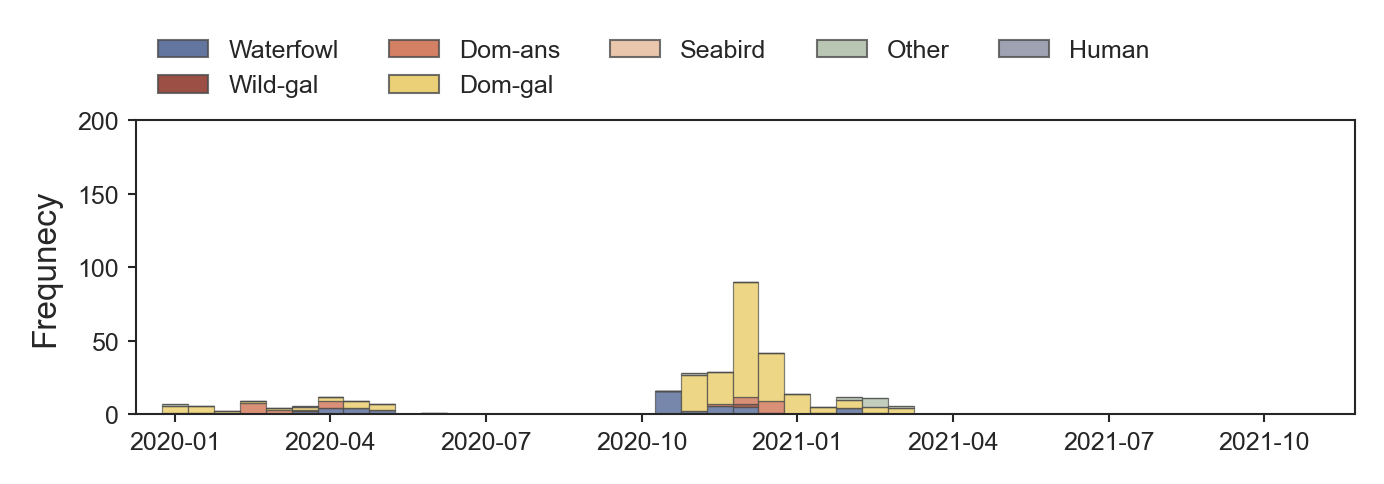

In [220]:
sns.set_theme(style="ticks")
sns.set_context({
    'xtick.labelsize': 6, 'xtick.major.width': .5, 'xtick.major.size': 2, 'xtick.major.pad': 2,
    'ytick.labelsize': 6, 'ytick.major.width': .5, 'ytick.major.size': 2, 'ytick.major.pad': 2,
    'font.size': 8., 'axes.labelsize': 8.0, 'axes.linewidth': .5})


host_l = ['Waterfowl', 'Wild-gal', 'Dom-ans', 'Dom-gal', 'Seabird', 'Other', 'Human']
color_seg = ['#3C5488', '#832316', '#ca613d', '#e8c555', '#e4b897', '#a9b8a2', '#878b9f']
host_cmap = dict(zip(host_l, color_seg))


metainfo_filter2_G0 = metainfo_filter2.query('genotype2 in @G0_series')

hist = {}
bins = pd.date_range('2019-12-01', '2021-11-30', freq='SM')
labels = bins[1:].map(lambda x: x.strftime('%Y-%m-%d'))
for host_i in host_l:
    df_i = metainfo_filter2_G0.query("host2 == @host_i")
    hist_i, _ = np.histogram(df_i['date'], bins=bins)
    hist[host_i] = hist_i


fig, ax = plt.subplots(figsize=(4.5, 1.5), dpi=300, constrained_layout=True)

bottom = np.zeros(len(labels))
for host_i in host_l:
    hist_i = hist[host_i]
    ax.bar(labels, hist_i, bottom=bottom, label=host_i, width=1, color=host_cmap[host_i], alpha=.7, edgecolor='.3', linewidth=0.3)
    bottom = bottom + hist_i
        
x_ticks = np.arange(1, len(labels), 6)
x_ticklabels = [x[0:7] for x in labels[x_ticks]]
ax.set(xticks=x_ticks, xticklabels=x_ticklabels)

ax.set_ylim(0, 200)
ax.set_ylabel("Frequnecy")

handles = [mpatches.Patch(facecolor=color, label=geno, alpha=.8, edgecolor='.3', linewidth=.5) for geno, color in host_cmap.items()]
ax.legend(
    handles=handles, 
    labels=host_l, 
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=5, fontsize=6
)

ax.set_xmargin(0)

# plt.savefig('./results/fig3c.pdf')
# plt.show()
plt.show()

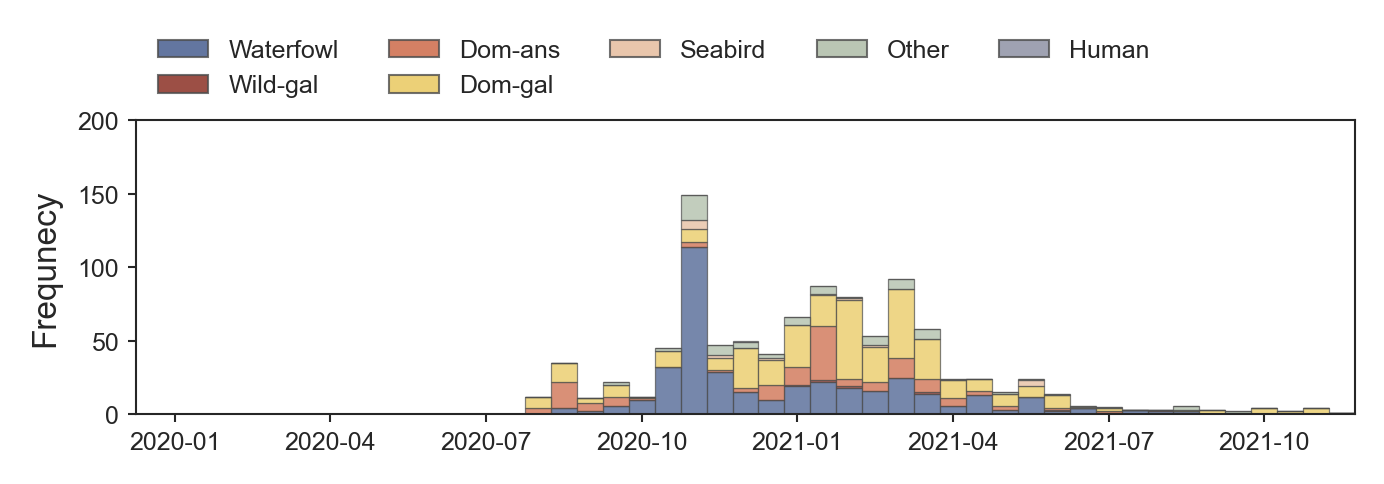

In [221]:
sns.set_theme(style="ticks")
sns.set_context({
    'xtick.labelsize': 6, 'xtick.major.width': .5, 'xtick.major.size': 2, 'xtick.major.pad': 2,
    'ytick.labelsize': 6, 'ytick.major.width': .5, 'ytick.major.size': 2, 'ytick.major.pad': 2,
    'font.size': 8., 'axes.labelsize': 8.0, 'axes.linewidth': .5})


host_l = ['Waterfowl', 'Wild-gal', 'Dom-ans', 'Dom-gal', 'Seabird', 'Other', 'Human']
color_seg = ['#3C5488', '#832316', '#ca613d', '#e8c555', '#e4b897', '#a9b8a2', '#878b9f']
host_cmap = dict(zip(host_l, color_seg))


metainfo_filter2_G1 = metainfo_filter2.query('genotype2 in @G1_series')

hist = {}
bins = pd.date_range('2019-12-01', '2021-11-30', freq='SM')
labels = bins[1:].map(lambda x: x.strftime('%Y-%m-%d'))
for host_i in host_l:
    df_i = metainfo_filter2_G1.query("host2 == @host_i")
    hist_i, _ = np.histogram(df_i['date'], bins=bins)
    hist[host_i] = hist_i


fig, ax = plt.subplots(figsize=(4.5, 1.5), dpi=300, constrained_layout=True)

bottom = np.zeros(len(labels))
for host_i in host_l:
    hist_i = hist[host_i]
    ax.bar(labels, hist_i, bottom=bottom, label=host_i, width=1, color=host_cmap[host_i], alpha=.7, edgecolor='.3', linewidth=0.3)
    bottom = bottom + hist_i
        
x_ticks = np.arange(1, len(labels), 6)
x_ticklabels = [x[0:7] for x in labels[x_ticks]]
ax.set(xticks=x_ticks, xticklabels=x_ticklabels)

ax.set_ylim(0, 200)
ax.set_ylabel("Frequnecy")

handles = [mpatches.Patch(facecolor=color, label=geno, alpha=.8, edgecolor='.3', linewidth=.5) for geno, color in host_cmap.items()]
ax.legend(
    handles=handles, 
    labels=host_l, 
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=5, fontsize=6
)

ax.set_xmargin(0)

# plt.savefig('./results/fig3c.pdf')
# plt.show()
plt.show()

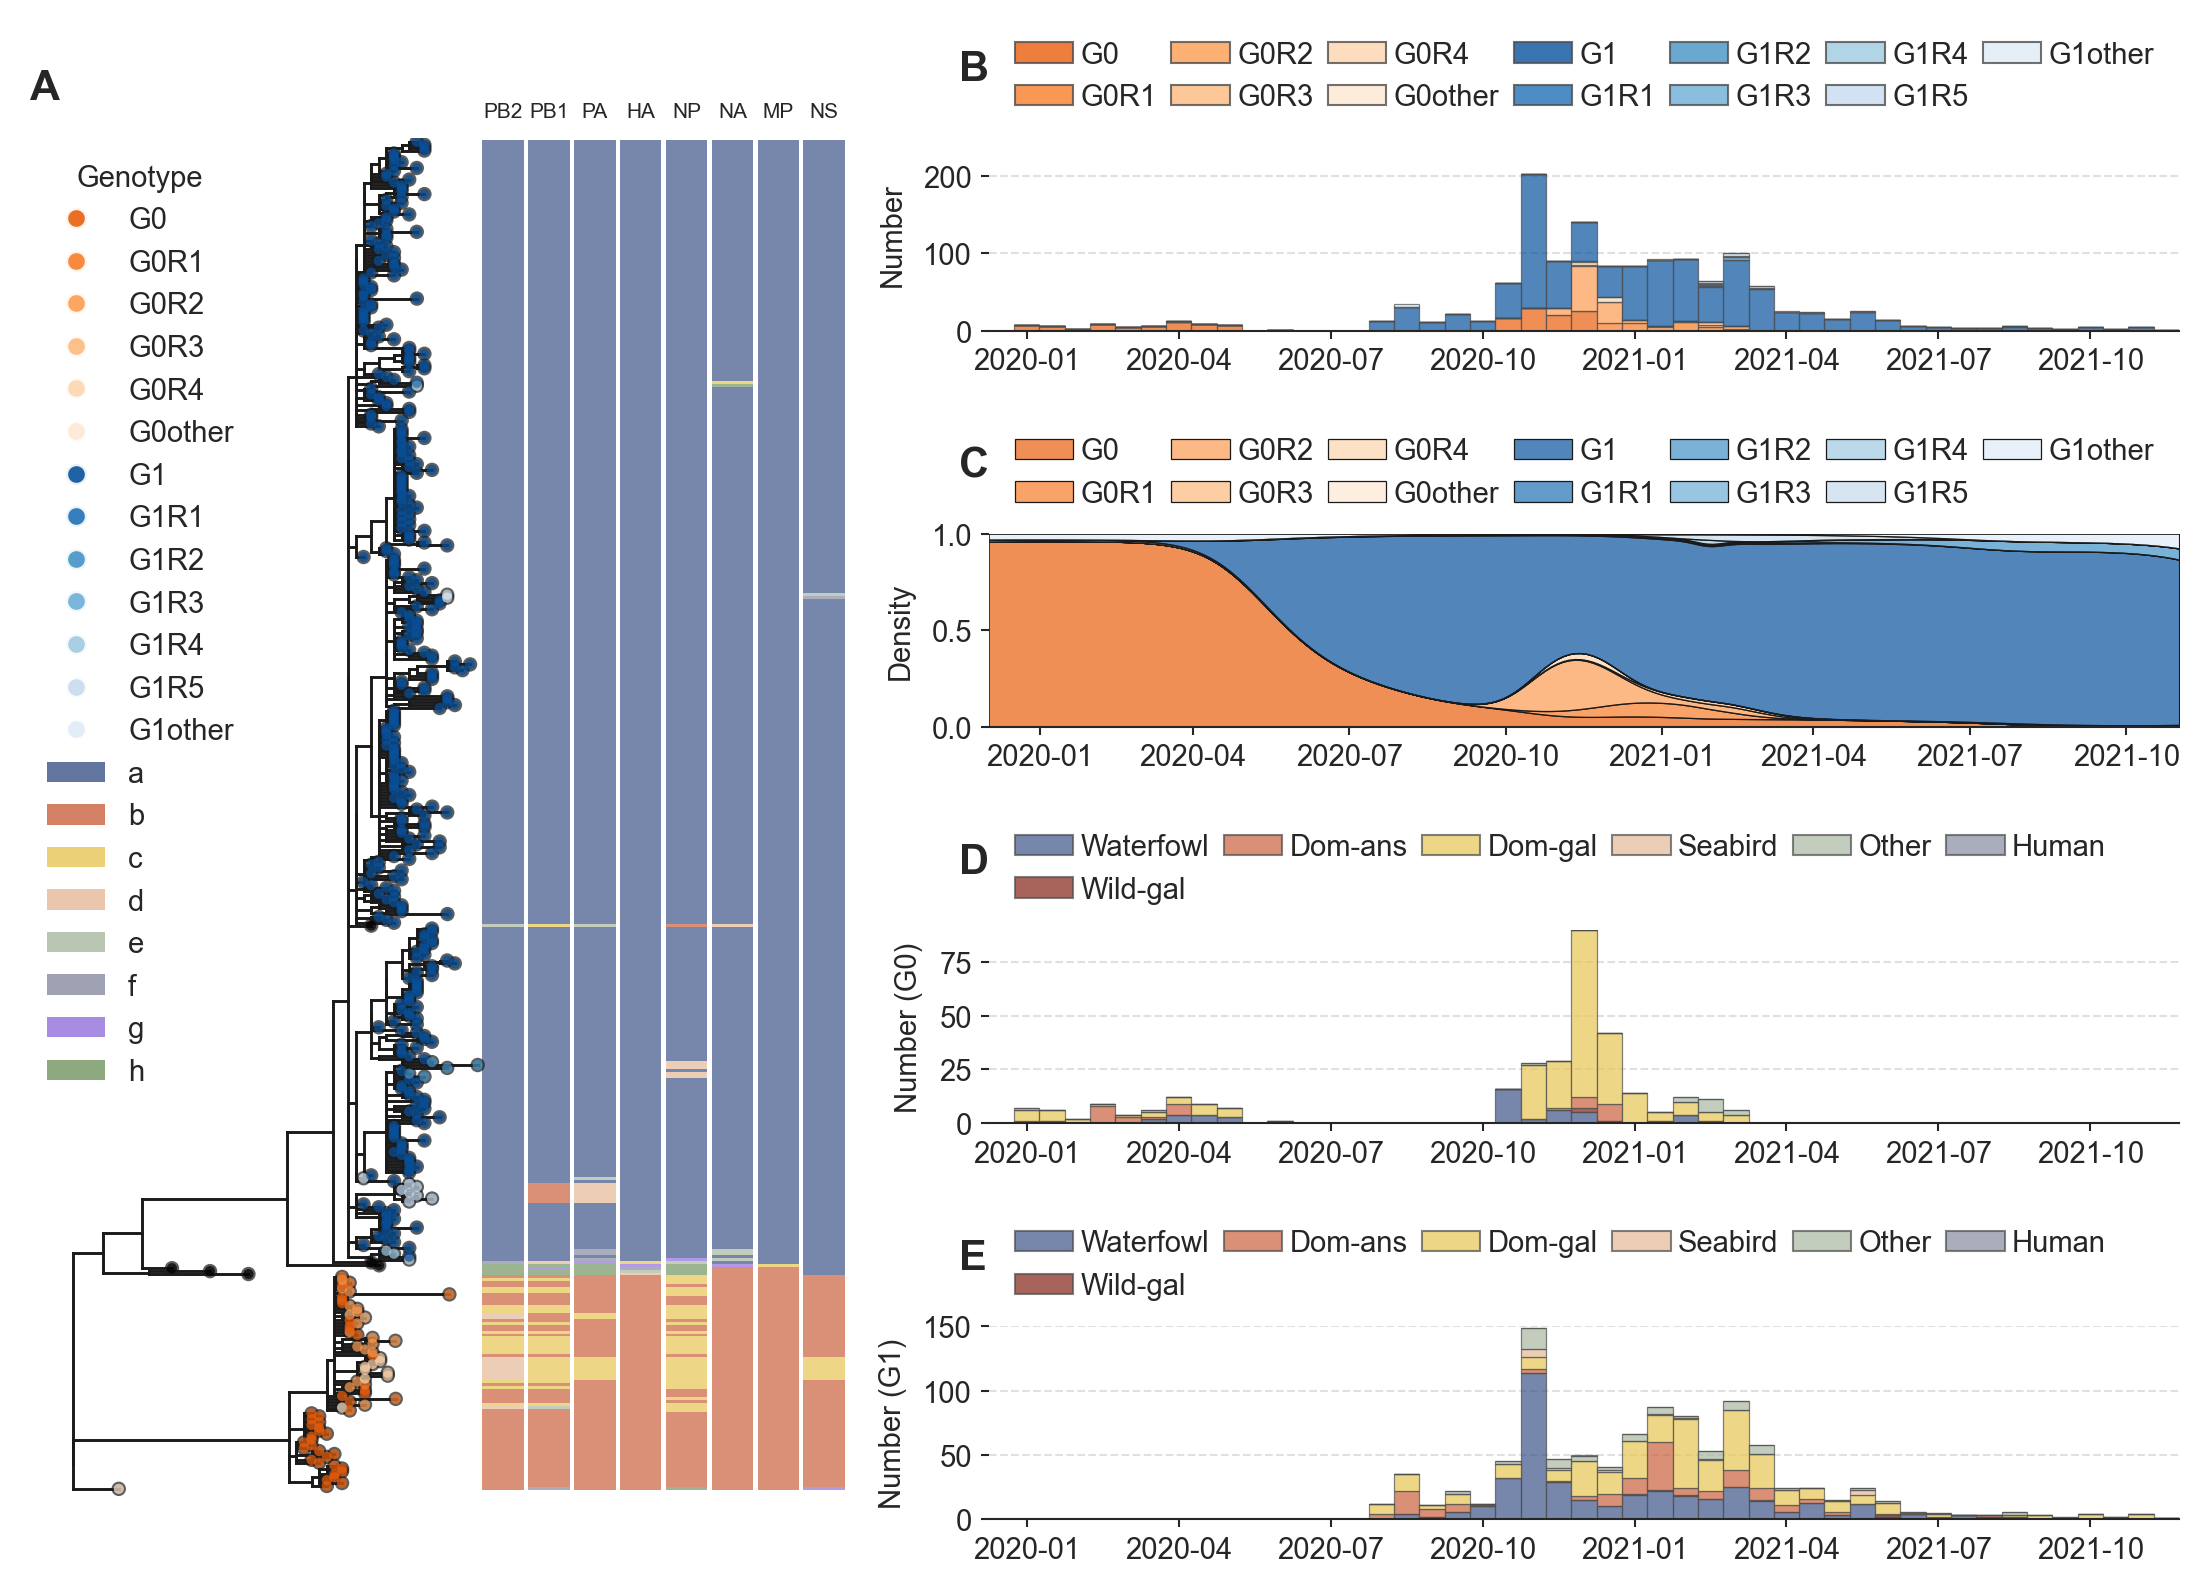

In [243]:
# scale = 10
index = 'abcdefghijklmnopq'
color_seg = ['#3C5488', '#ca613d', '#e8c555', '#e4b897', '#a9b8a2', '#878b9f', 'mediumpurple', '#729461', '#729461', '#729461', '#729461', '#729461', '#729461']

fig = plt.figure(figsize=(7.25, 5.2), facecolor='w', dpi=300, layout='compressed')

spec = fig.add_gridspec(4, 2,  width_ratios=[1, 1.5])
trans = ScaledTranslation(-30/300, 30/300, fig.dpi_scale_trans)

ax = fig.add_subplot(spec[:, 0])
ax.text(0.0, 1.0, 'A', transform=ax.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

y_attr=lambda k: -k.y
color_func=lambda k: genotype_cmap.get(k.traits['genotype2'], 'black')

ll.plotTree(ax, y_attr=y_attr, width=.7)
ll.plotPoints(ax, y_attr=y_attr, colour=color_func, size=6, zorder=100, alpha=.7)

# add gene group annotation
w = ll.treeHeight/10
skip = w / 10
h = 1

for leaf in ll.getExternal():
    y = leaf.y
    genotype_ = leaf.traits['genotype']

    if not genotype_:
        continue

    for s in range(8):
        seg_group_index = index.index(genotype_[s])
        base=ll.treeHeight + skip ## where reassortment indicator boxes begin
        rect=plt.Rectangle(
            (base+s*(w+skip),-leaf.y-h/2),w,h,
            facecolor=color_seg[seg_group_index], edgecolor='none',
            lw=.0, alpha=.7
        )
        ax.add_patch(rect) ## add rectangle to plot            

# add gene name
for i, seg in enumerate(segments):
    ax.text(base+i*(w+skip)+w/2, 10, seg, fontsize=5, horizontalalignment='center', verticalalignment='center', rotation=0)

# add legend
handles = []
for k, v in genotype_cmap.items():
    handles.append(Line2D([0], [0], marker='o', markerfacecolor=v, lw=0, label=k, alpha=.9, markersize=5, color='w'))

for group, color in zip('abcdefgh', color_seg[0:8]):
    handles.append(mpatches.Patch(facecolor=color, label=group, alpha=.8, edgecolor='1', linewidth=0))

ax.legend(handles=handles, frameon=False, fontsize=7, loc='upper left', bbox_to_anchor=(-.05, 1), title='Genotype', title_fontsize=7)

# set other
ax.set_xlim(0, ll.treeHeight+w*9)
ax.set_xticks([])
ax.set_yticklabels([])

ax.set_ylim(-10-ll.ySpan, 1) ## set y limits
ax.set_yticks([])
ax.set_yticklabels([])

[ax.spines[loc].set_visible(False) for loc in ax.spines]


# ******************************************************************************************************
ax1 = fig.add_subplot(spec[0, 1])
ax1.text(0.0, 1.1, 'B', transform=ax1.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')


bins = pd.date_range('2019-12-01', '2021-11-30', freq='SM')
labels = bins[1:].map(lambda x: x.strftime('%Y-%m-%d'))

hist = {}
for genotype_i in G1_series+G0_series:
    df_i = metainfo_filter2.query("genotype2 == @genotype_i")
    hist_i, _ = np.histogram(df_i['date'], bins=bins)
    hist[genotype_i] = hist_i
    
bottom = np.zeros(len(labels))
for genotype_i in (G0_series+G1_series):
    hist_i = hist[genotype_i]
    ax1.bar(labels, hist_i, bottom=bottom, label=genotype_i, width=1, color=genotype_cmap[genotype_i], alpha=.7, edgecolor='.3', linewidth=0.3)
    bottom = bottom + hist_i
        
x_ticks = np.arange(1, len(labels), 6)
x_ticklabels = [x[0:7] for x in labels[x_ticks]]
ax1.set(xticks=x_ticks, xticklabels=x_ticklabels)
ax1.tick_params(axis='both', length=2, labelsize=7)

ax1.set_ylim(0, 250)
ax1.set_ylabel("Number", fontsize=7)
ax1.grid(axis='y', lw=.5, ls='--', alpha=.6)

handles = [mpatches.Patch(facecolor=color, label=geno, alpha=.8, edgecolor='.3', linewidth=.5) for geno, color in genotype_cmap.items()]
ax1.legend(
    handles=handles, 
    labels=G0_series+G1_series, 
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=7, fontsize=7, columnspacing=.5, handletextpad=0.25
)

ax1.set_xmargin(0)
ax1.spines[['left', 'top', 'right']].set_visible(False)

# ******************************************************************************************************
ax2 = fig.add_subplot(spec[1, 1])
ax2.text(0.0, 1.1, 'C', transform=ax2.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')
sns.kdeplot(
    ax=ax2, data=metainfo_filter2, x="date", 
    hue="genotype2", hue_order=(G0_series+G1_series)[::-1],
    multiple="fill", bw_adjust=2, clip=(0, None), cut=0, common_norm=True, palette=genotype_cmap,
    alpha=.7, linewidth=.3, edgecolor=".1", legend=True,
    warn_singular=False
)

ax2.legend(
    labels=G0_series+G1_series,
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=7, fontsize=7, columnspacing=.5, handletextpad=0.25
)
ax2.set_xlabel('')
ax2.set_ylabel('Density', fontdict={'fontsize': 7})

ax2.xaxis.set_major_formatter(mdate.DateFormatter("%Y-%m"))
plt.xticks(pd.date_range('2020-01-01', '2021-12-31', freq='3M'))
ax2.tick_params(axis='both', length=2, labelsize=7)

for label in ax2.get_xticklabels():
    label.set(rotation=0)

ax2.grid(False)
ax2.spines[['left', 'top', 'right']].set_visible(False)

# ******************************************************************************************************
ax3 = fig.add_subplot(spec[2, 1])
ax3.text(0.0, 1.1, 'D', transform=ax3.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

metainfo_filter2_G0 = metainfo_filter2.query('genotype2 in @G0_series')

hist = {}
bins = pd.date_range('2019-12-01', '2021-11-30', freq='SM')
labels = bins[1:].map(lambda x: x.strftime('%Y-%m-%d'))
for host_i in host_l:
    df_i = metainfo_filter2_G0.query("host2 == @host_i")
    hist_i, _ = np.histogram(df_i['date'], bins=bins)
    hist[host_i] = hist_i

bottom = np.zeros(len(labels))
for host_i in host_l:
    hist_i = hist[host_i]
    ax3.bar(labels, hist_i, bottom=bottom, label=host_i, width=1, color=host_cmap[host_i], alpha=.7, edgecolor='.3', linewidth=0.3)
    bottom = bottom + hist_i
        
x_ticks = np.arange(1, len(labels), 6)
x_ticklabels = [x[0:7] for x in labels[x_ticks]]
ax3.set(xticks=x_ticks, xticklabels=x_ticklabels)
ax3.set_xmargin(0)
ax3.tick_params(axis='both', length=2, labelsize=7)

# ax3.set_ylim(0, 200)
ax3.set_yticks([0, 25, 50, 75])
ax3.set_ylabel("Number (G0)", fontsize=7)
ax3.grid(axis='y', lw=.5, ls='--', alpha=.6)

handles = [mpatches.Patch(facecolor=color, label=geno, alpha=.7, edgecolor='.3', linewidth=.5) for geno, color in host_cmap.items()]
ax3.legend(
    handles=handles, 
    labels=host_l, 
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=6, fontsize=7, columnspacing=.5, handletextpad=0.25
)
ax3.spines[['left', 'top', 'right']].set_visible(False)

# ******************************************************************************************************
ax4 = fig.add_subplot(spec[3, 1])
ax4.text(0.0, 1.1, 'E', transform=ax4.transAxes+trans, fontsize=10, weight='bold', va='bottom', fontfamily='Arial')

metainfo_filter2_G1 = metainfo_filter2.query('genotype2 in @G1_series')

hist = {}
bins = pd.date_range('2019-12-01', '2021-11-30', freq='SM')
labels = bins[1:].map(lambda x: x.strftime('%Y-%m-%d'))
for host_i in host_l:
    df_i = metainfo_filter2_G1.query("host2 == @host_i")
    hist_i, _ = np.histogram(df_i['date'], bins=bins)
    hist[host_i] = hist_i

bottom = np.zeros(len(labels))
for host_i in host_l:
    hist_i = hist[host_i]
    ax4.bar(labels, hist_i, bottom=bottom, label=host_i, width=1, color=host_cmap[host_i], alpha=.7, edgecolor='.3', linewidth=0.3)
    bottom = bottom + hist_i
        
x_ticks = np.arange(1, len(labels), 6)
x_ticklabels = [x[0:7] for x in labels[x_ticks]]
ax4.set(xticks=x_ticks, xticklabels=x_ticklabels)
ax4.set_xmargin(0)
ax4.tick_params(axis='both', length=2, labelsize=7)

# ax4.set_ylim(0, 200)
ax4.set_yticks([0, 50, 100, 150])
ax4.set_ylabel("Number (G1)", fontsize=7)
ax4.grid(axis='y', lw=.5, ls='--', alpha=.6)

handles = [mpatches.Patch(facecolor=color, label=geno, alpha=.7, edgecolor='.3', linewidth=.5) for geno, color in host_cmap.items()]
ax4.legend(
    handles=handles, 
    labels=host_l, 
    frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=6, fontsize=7, columnspacing=.5, handletextpad=0.25
)

ax4.spines[['left', 'top', 'right']].set_visible(False)
plt.savefig('./results/Fig4.pdf')

plt.show()

# spatial temporal dynamic of different genotypes

In [538]:

tmp = metainfo_filter2.query("HA == 'b'")
ts = tmp['date'].map(lambda x: x.to_period('M'))
tmp = tmp.groupby([ts, tmp.Country]).size().unstack(1).resample('M').sum()


tmp['Japan']

date
2020-01      NaN
2020-02      NaN
2020-03      NaN
2020-04      NaN
2020-05      NaN
2020-06      NaN
2020-07      NaN
2020-08      NaN
2020-09      NaN
2020-10      1.0
2020-11     54.0
2020-12    100.0
2021-01     19.0
2021-02     22.0
2021-03      6.0
Freq: M, Name: Japan, dtype: float64

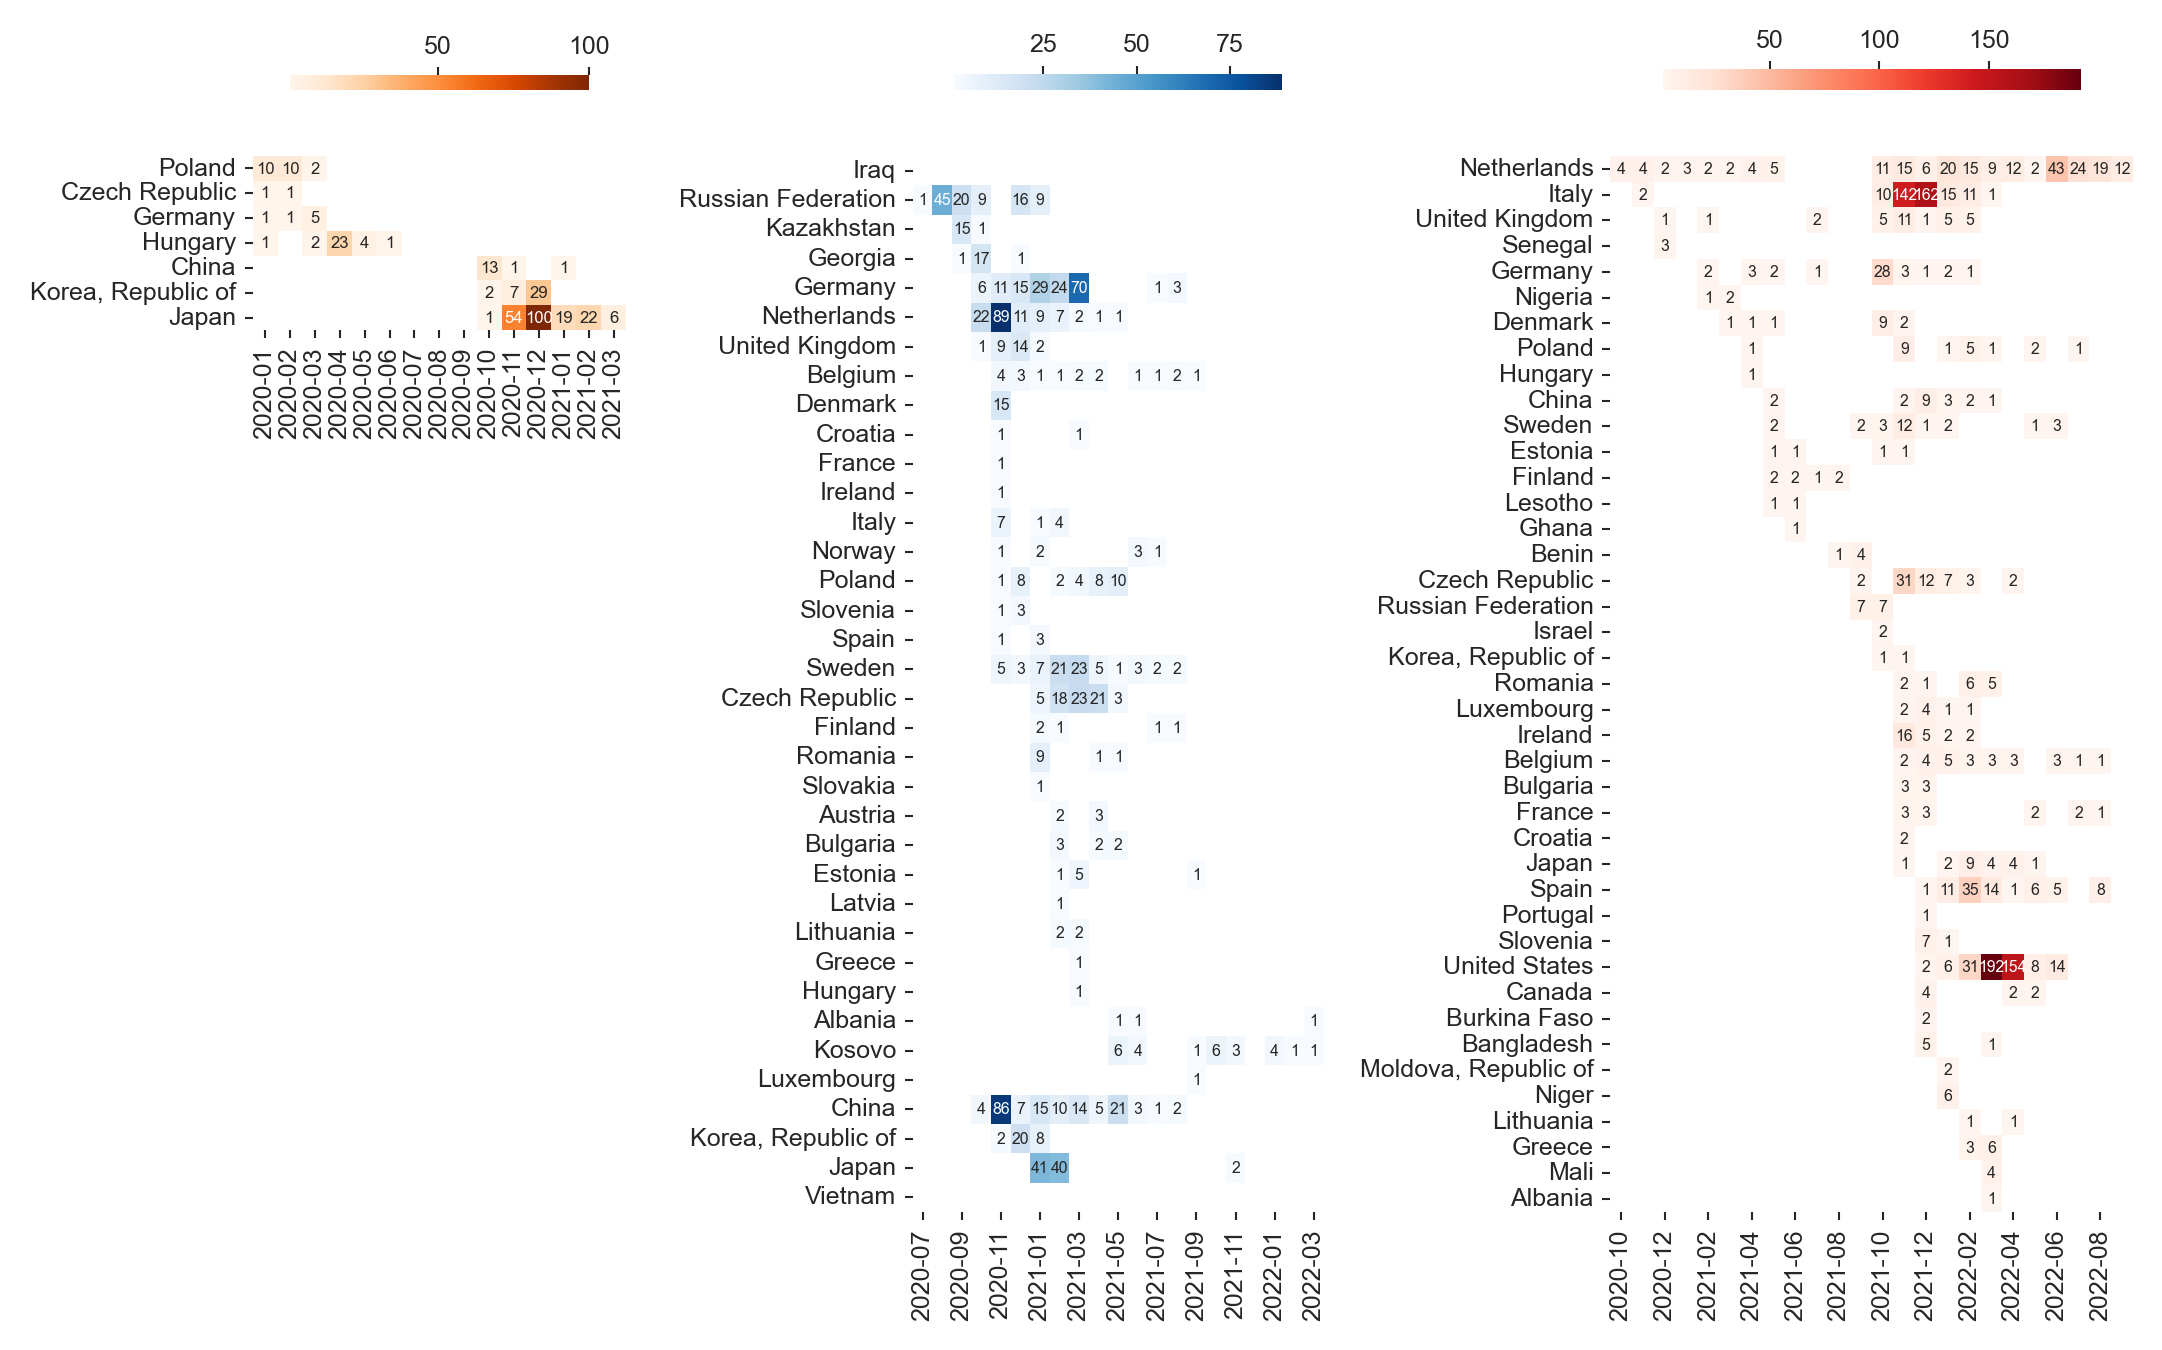

In [619]:
country_order_G0 = ['Poland', 'Czech Republic', 'Germany', 'Hungary', 'China', 'Korea, Republic of', 'Japan']

country_order_G1 = ['Iraq', 'Russian Federation', 'Kazakhstan', 'Georgia', 'Germany','Netherlands', 'United Kingdom',  'Belgium', 'Denmark', 'Croatia','France', 'Ireland', 'Italy',  'Norway', 'Poland', 'Slovenia', 'Spain', 'Sweden',
'Czech Republic',  'Finland', 'Romania', 'Slovakia', 'Austria', 'Bulgaria', 'Estonia','Latvia', 'Lithuania','Greece', 'Hungary',  'Albania', 'Kosovo', 'Luxembourg',  'China', 'Korea, Republic of', 'Japan','Vietnam']

country_order_N1 = ['Netherlands', 'Italy', 'United Kingdom', 'Senegal', 'Germany',
       'Nigeria', 'Denmark', 'Poland', 'Hungary', 'China', 'Sweden', 'Estonia',
       'Finland', 'Lesotho', 'Ghana', 'Benin', 'Czech Republic',
       'Russian Federation', 'Israel', 'Korea, Republic of', 'Romania',
       'Luxembourg', 'Ireland', 'Belgium', 'Bulgaria', 'France', 'Croatia',
       'Japan', 'Spain', 'Portugal', 'Slovenia', 'United States', 'Canada',
       'Burkina Faso', 'Bangladesh', 'Moldova, Republic of', 'Niger',
       'Lithuania', 'Greece', 'Mali', 'Albania']



fig, axes = plt.subplots(1,3, figsize=(7.25, 5), dpi=300, width_ratios=[1, 1.1, 1.4])

tmp = metainfo_filter2.query("HA == 'b'")
ts = tmp['date'].map(lambda x: x.to_period('M'))
tmp = tmp.groupby([ts, tmp.Country]).size().unstack(1).resample('M').sum()
sns.heatmap(tmp.T.reindex(country_order_G0), 
            cmap='Oranges', fmt=".0f", annot=True, ax=axes[0], 
            cbar_kws={'shrink': 0.8, 'location': 'top'}, annot_kws={'fontsize': 4}, 
            yticklabels=True, xticklabels=True, square=True)
axes[0].set(xlabel="", ylabel="")


tmp = metainfo_filter2.query("HA == 'a'")
ts = tmp['date'].map(lambda x: x.to_period('M'))
tmp = tmp.groupby([ts, tmp.Country]).size().unstack(1).resample('M').sum()
sns.heatmap(tmp.T.reindex(country_order_G1),
            cmap='Blues', fmt=".0f", annot=True, ax=axes[1], 
            cbar_kws={'shrink': 0.8, 'location': 'top'}, annot_kws={'fontsize': 3.8}, 
            yticklabels=True, xticklabels=True, square=False)
axes[1].set(xlabel="", ylabel="")
ticks = axes[1].get_xticks()
axes[1].set_xticks(ticks[::2])

tmp = n1_set
ts = pd.to_datetime(tmp['date']).map(lambda x: x.to_period('M'))
tmp = tmp.groupby([ts, tmp.country]).size().unstack(1).resample('M').sum()
sns.heatmap(tmp.T.reindex(country_order_N1), 
            cmap='Reds', fmt=".0f", annot=True, ax=axes[2], 
            cbar_kws={'shrink': 0.8, 'location': 'top'}, annot_kws={'fontsize': 3.8}, 
            yticklabels=True, xticklabels=True, square=False)
axes[2].set(xlabel="", ylabel="")
ticks = axes[2].get_xticks()
axes[2].set_xticks(ticks[::2])


plt.tight_layout()
# plt.savefig('./results/sfig3.pdf')
plt.show()

# draw tangle trees

In [328]:
segments = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']

trees = {}
deltas = {}
ySpans = {}

skip = 0
cum_height = 0

for i, segment in enumerate(segments):

    tree_file = f'./data/01_19to21_h5n8/h5n8_{segment}.align.fasta.treefile'
    tree = dendropy.Tree.get(path=tree_file, schema='newick', extract_comment_metadata=True)
    tree.reroot_at_midpoint(update_bipartitions=False)
    tree.ladderize(ascending=False)
    
    seg_with_full_genome = df.query('Isolate_Id in @isl_with_full_genome')[segment].to_list()
    tree.retain_taxa_with_labels(seg_with_full_genome)

    treeString = tree.as_string(schema='newick', suppress_rooting=True, suppress_annotations=True, annotations_as_nhx=False)
    f = StringIO()
    f.write(treeString)
    f.seek(0)
    
    ll=bt.loadNewick(f,tip_regex='_([0-9\-]+)$', absoluteTime=False)
    ll.renameTips(seg2isl)
    f.close()

    if i == 0:
        skip = ll.treeHeight * .5
        
    trees[segment] = ll
    ySpans[segment] = ll.ySpan
    deltas[segment] = cum_height
    
    cum_height += ll.treeHeight + skip


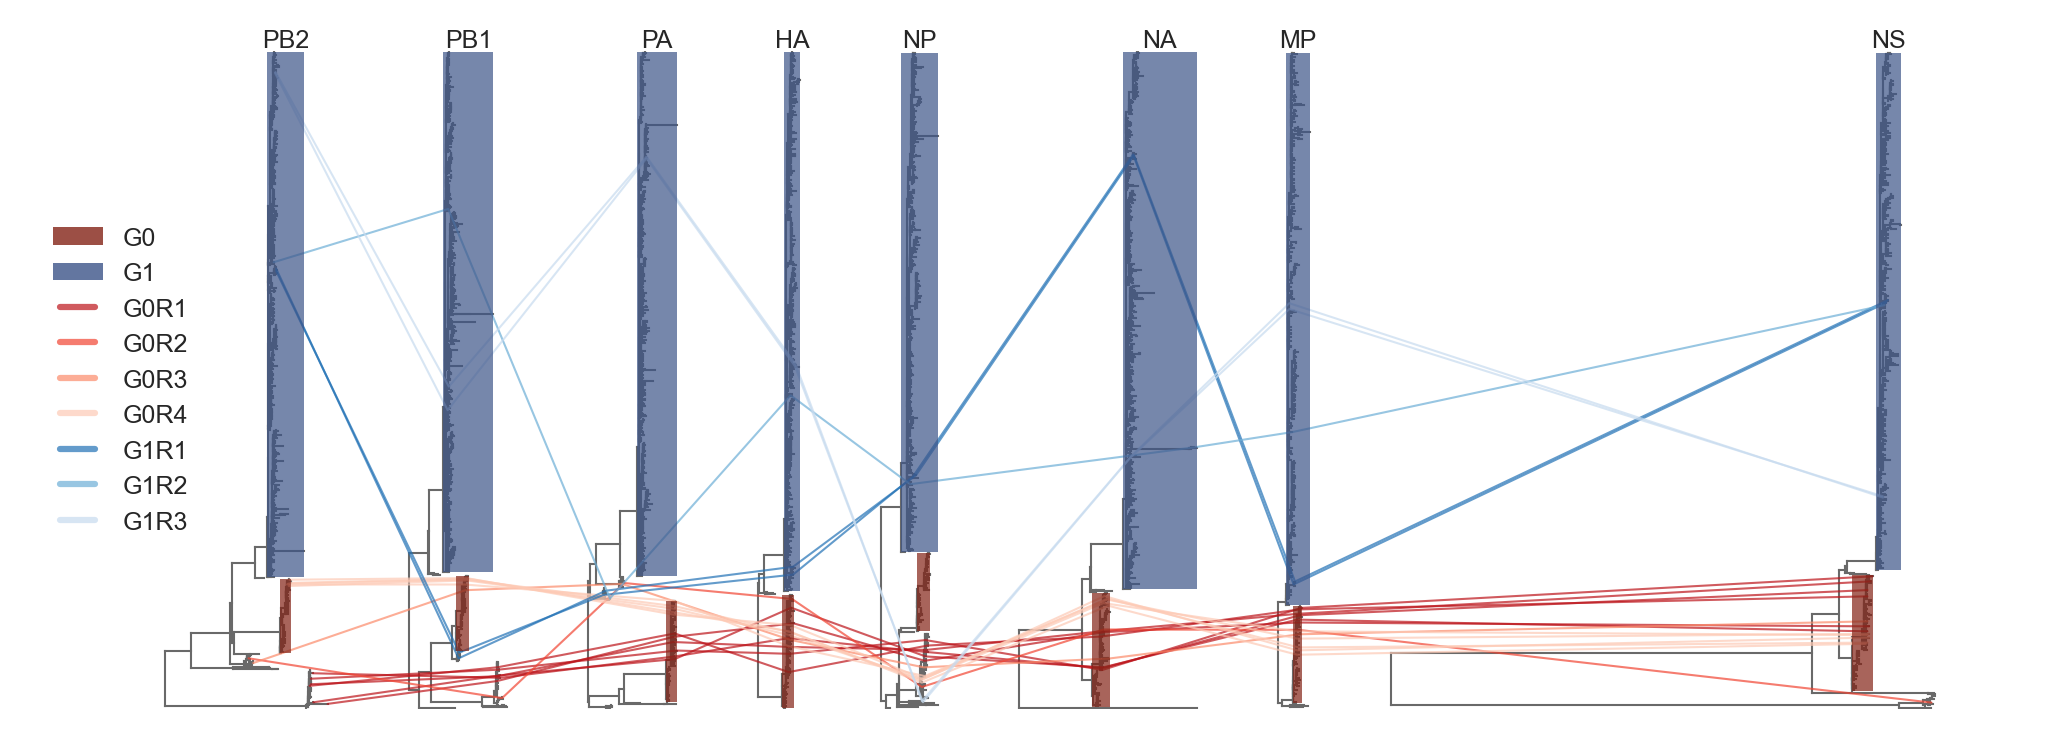

In [332]:
fig = plt.subplots(figsize=(6.75, 2.35),facecolor='w',dpi=300,constrained_layout=True)
ax = plt.subplot(1,1,1)


for i, segment in enumerate(segments):
    
    tree = trees[segment]
    delta = deltas[segment]
    
    y_tran = lambda x: -x*ySpans['PB2']/ySpans[segment]
    
    for geno, color in zip(['aaaaaaaa', 'bbbbbbbb'], ['#3C5488', '#832316']):
    
        name_intr_i = df4.query("genotype == @geno").index.to_list()
        hightlight = tree.commonAncestor(list(filter(lambda x: x.branchType=='leaf' and x.name in name_intr_i, tree.Objects)))
        (upper, lower), left, right = hightlight.yRange, hightlight.height, hightlight.childHeight
        left += deltas[segment]
        right += deltas[segment]
        lower = y_tran(lower)
        upper = y_tran(upper)
        width = right - left
        height = upper - lower
        
        rect = Rectangle((left, lower), width, height, facecolor=color, edgecolor='none', lw=1, ls='-', zorder=100, alpha=.7) ## create rectangle
        ax.add_patch(rect) ## add rectangle to plot

        if geno == 'aaaaaaaa':
            ax.text(left+width/2, 0, segment, ha='center', va='bottom', fontdict={'fontsize': 6})

    x_attr=lambda k: delta+k.height ## for tree2 we'll offset x coordinates by the height of the tree and invert branches
    y_attr=lambda k: y_tran(k.y)
    
    tree.plotTree(ax, x_attr=x_attr, y_attr=y_attr, width=.5, colour='dimgrey') ## plot black tree


geno_re = ['ccbbcbbb', 'dccbcbbc', 'dbcbcbbb', 'bbbbcbbb', 'addaaaaa', 'aafaaaaa', 'aaaadaaa']

for i, geno in enumerate(geno_re):
    
    name_intr_i = df4.query("genotype == @geno").index.to_list()
    
    for k in name_intr_i:
        try:
            branchs = {seg: trees[seg].getBranches(lambda x: x.branchType=='leaf' and x.name==k) for seg in segments}
            
            xs = list(map(lambda x: x[0]+x[1], [(branchs[seg].x, deltas[seg]) for seg in segments]))
            ys = list(map(lambda x: -x[0]*ySpans['PB2']/x[1], [(branchs[seg].y, ySpans[seg]) for seg in segments]))
            color = genotype_cmap[geno]
            ax.plot(xs, ys, color=color, alpha=.7, lw=.5)
        except:
            pass


## add legend
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

handles = []
for geno, color in zip(['bbbbbbbb', 'aaaaaaaa', ], ['#832316', '#3C5488', ]):
    handles.append(mpatches.Patch(facecolor=color, label=geno, alpha=.8, edgecolor='none'))
for i, geno in enumerate(geno_re):
    handles.append(Line2D([0], [0], color=genotype_cmap[geno], lw=1.5, label=geno, alpha=.7))

# plt.legend(handles=handles, frameon=False, fontsize=6, loc='lower left', bbox_to_anchor=(0.05, 1.05), ncol=7)
ax.legend(loc='center left', handles=handles, frameon=False, fontsize=6, labels=['G0', 'G1', 'G0R1', 'G0R2', 'G0R3', 'G0R4', 'G1R1', 'G1R2', 'G1R3', ])

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(-ySpans['PB2']-1,1) ## set y limits
ax.set_xlim(-.1,cum_height+.01)

plt.savefig('./results/fig3b.pdf')
plt.show()


**Fig3b**

**Fig 3a**

In [9]:
G0_Ne = pd.read_csv('./data/01_ha_for_beast/G0_Ne.csv', skiprows=1, sep='\t')
G0_Ne['Time2'] = pd.to_datetime(G0_Ne.Time.map(lambda x: bt.calendarDate(x)))

G1_Ne = pd.read_csv('./data/01_ha_for_beast/G1_Ne.csv', skiprows=1, sep='\t')
G1_Ne['Time2'] = pd.to_datetime(G1_Ne.Time.map(lambda x: bt.calendarDate(x)))
G1_Ne.head()

,Time,Mean,Median,Upper,Lower,Time2
0,2022.161600,0.739024,0.667424,8.629321,0.076858,2022-02-28
1,2022.119227,0.705238,0.642181,6.044363,0.088105,2022-02-13
2,2022.076854,0.654152,0.598883,4.580413,0.115297,2022-01-29
3,2022.034481,0.564464,0.528485,3.002018,0.115477,2022-01-13
4,2021.992108,0.490107,0.466538,2.192016,0.117135,2021-12-29


In [10]:
sns.set_theme(style="ticks")
sns.set_context({
    'xtick.labelsize': 6, 'xtick.major.width': .5, 'xtick.major.size': 2, 'xtick.major.pad': 2,
    'ytick.labelsize': 6, 'ytick.major.width': .5, 'ytick.major.size': 2, 'ytick.major.pad': 2, 'ytick.minor.width': .5, 'ytick.minor.size': 1,
    'font.size': 8., 'axes.labelsize': 8.0, 'axes.linewidth': .5})

In [11]:
from datetime import datetime

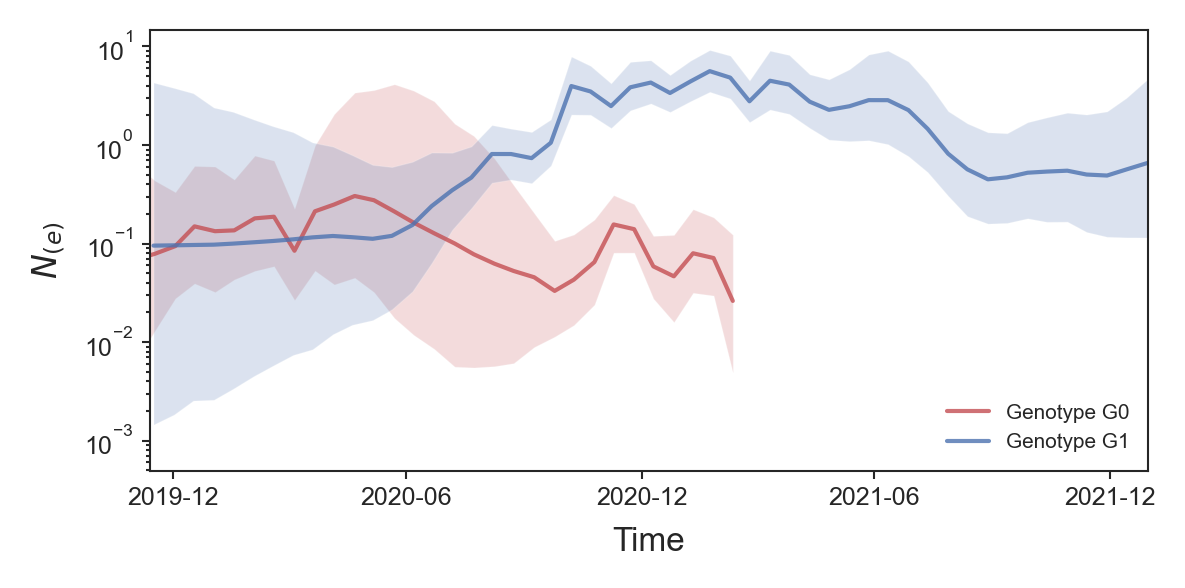

In [22]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)

with mpl.rc_context({'font.family': 'Arial', 'font.size': 8, 'hatch.linewidth': .5, 'lines.linewidth': .3, 'patch.linewidth': .3, 'ytick.minor.size':.1, 'ytick.minor.width':0.01, 'axes.xmargin': 0}):
    
    ax.plot('Time2', 'Mean', '-', data=G0_Ne, color='C3', alpha=.8, lw=1, label='Genotype G0')
    ax.fill_between('Time2', 'Lower', 'Upper', data=G0_Ne, color='C3', alpha=0.2, edgecolor='white')

    ax.plot('Time2', 'Mean', '-', data=G1_Ne, color='C0', alpha=.8, lw=1, label='Genotype G1')
    ax.fill_between('Time2', 'Lower', 'Upper', data=G1_Ne, color='C0', alpha=0.2, edgecolor='white')
    
#     ax.set_ylim(10e-5, 10e1)
    ax.set_yscale('log')
    ax.set(xlabel='Time', ylabel='$N_{(e)}$')
    
    ax.set_xlim([datetime(2019,12,13), datetime(2022,1,30)])
    ax.legend(loc=4,fontsize=5,frameon=False)

    ax.xaxis.set_major_formatter(mdate.DateFormatter("%Y-%m"))
    plt.xticks(pd.date_range('2019-12-31', '2022-01-30', freq='6M'))
    
    plt.tight_layout()
    plt.savefig('./results/fig7b.pdf')
    plt.show()